<a href="https://colab.research.google.com/github/RAFS20/Analisis-de-datos/blob/main/Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Analysis Function

In [1]:
!pip install pandas numpy matplotlib seaborn scipy scikit-learn statsmodels openpyxl python-docx joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from scipy.stats import shapiro, levene, chi2_contingency
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import matplotlib.colors as mcolors
from datetime import datetime
import joblib
from docx import Document
from docx.shared import Inches
import warnings

# Ignore specific warnings from SciPy and pandas to keep the output clean
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Global configuration to display only 2 decimal places
sys.displayhook = lambda x: print(f'{round(x, 2):.2f}')
sns.set(style='white')
plt.rcParams.update({'font.family': 'Liberation Serif', 'font.size': 12})

def create_base_folders():
    """
    Creates a base folder with the current date and time, and subfolders for results.

    Returns:
        dict: Dictionary with paths of the created folders.
    """
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    base_dir = f"Analyzed_Dataset_{timestamp}"
    subfolders = {
        'images': os.path.join(base_dir, 'images'),
        'tables': os.path.join(base_dir, 'tables'),
        'models': os.path.join(base_dir, 'models'),
        'reports': os.path.join(base_dir, 'reports')
    }
    for folder in subfolders.values():
        os.makedirs(folder, exist_ok=True)
    return subfolders

def load_dataset(file_path):
    """
    Loads the dataset from a CSV file.

    Args:
        file_path (str): Path to the CSV file.

    Returns:
        pd.DataFrame: The loaded dataset as a Pandas DataFrame.
    """
    try:
        return pd.read_csv(file_path)
    except Exception as e:
        print(f"Error loading file: {e}")
        sys.exit(1)

def dataset_summary(dataset, tables_dir):
    """
    Displays a general summary of the dataset and saves the summary in Excel.

    Args:
        dataset (pd.DataFrame): The dataset to summarize.
        tables_dir (str): Path to the folder where the table will be saved.
    """
    summary = {
        'Number of Rows': [dataset.shape[0]],
        'Number of Columns': [dataset.shape[1]]
    }
    summary_df = pd.DataFrame(summary)
    print("Dataset Summary:")
    print(summary_df)
    summary_df.to_excel(os.path.join(tables_dir, 'dataset_summary.xlsx'), index=False)

def analyze_missing_values(dataset, tables_dir):
    """
    Analyzes missing values in the dataset and saves the summary in Excel.

    Args:
        dataset (pd.DataFrame): The dataset to analyze.
        tables_dir (str): Path to the folder where the table will be saved.
    """
    missing_values = dataset.isnull().sum().reset_index()
    missing_values.columns = ['Column', 'Missing_Values']
    print("Missing values per column:")
    print(missing_values)
    missing_values.to_excel(os.path.join(tables_dir, 'missing_values.xlsx'), index=False)

def analyze_numerical_variables(dataset, save_path, tables_dir):
    """
    Analyzes the numerical variables of the dataset, generates graphs, and saves statistics.

    Args:
        dataset (pd.DataFrame): The dataset to analyze.
        save_path (str): Path to the folder where the graphs will be saved.
        tables_dir (str): Path to the folder where the tables will be saved.
    """
    numerical_columns = dataset.select_dtypes(include=[np.number])
    if len(numerical_columns) > 0:
        print("Numerical Variables:")
        description = numerical_columns.describe().transpose()
        print(description)
        description.to_excel(os.path.join(tables_dir, 'numerical_variables_description.xlsx'))

        # Plot histograms and pie charts for each numerical variable and save the graphs
        for column in numerical_columns:
            plt.figure(figsize=(12, 6))

            # Histogram
            plt.subplot(1, 2, 1)
            sns.histplot(data=dataset, x=column, kde=True, color='skyblue')
            plt.axvline(dataset[column].median(), color='red', linestyle='--', label=f'Median: {dataset[column].median():.2f}')
            mean_value = dataset[column].mean()
            std_value = dataset[column].std()
            cv = std_value / abs(mean_value) if abs(mean_value) > 0.01 else std_value
            plt.axvline(mean_value, color='green', linestyle='--', label=f'Mean: {mean_value:.2f} CV: {cv:.2%}')
            plt.xlabel(column)
            plt.ylabel('Frequency')
            plt.title(f'Histogram of {column}')
            plt.legend()

            # Pie chart with intervals
            plt.subplot(1, 2, 2)
            min_val = dataset[column].min()
            max_val = dataset[column].max()
            # Removed 'observed=True' which is not valid for pd.cut
            bins = pd.cut(dataset[column], bins=5, include_lowest=True, precision=2, right=False)
            bin_counts = bins.value_counts(normalize=True).sort_index()
            percentages = bin_counts * 100
            labels = [f'{interval.left:.2f} - {interval.right:.2f} ({percentage:.2f}%)'
                      for interval, percentage in zip(bin_counts.index, percentages)]
            plt.pie(bin_counts, labels=None, autopct=None, startangle=90)
            plt.title(f'Pie Chart - {column} Intervals')
            plt.legend(labels, loc='center left', bbox_to_anchor=(1, 0.5))

            plt.suptitle(f'Analysis of {column}', y=1.05)
            plt.tight_layout()
            plt.savefig(os.path.join(save_path, f'analysis_{column}'), format='svg')
            plt.savefig(os.path.join(save_path, f'analysis_{column}.png'), format='png')
            plt.show()
    else:
        print("No numerical variables found in the dataset.")

def analyze_categorical_variables(dataset, save_path, tables_dir):
    """
    Analyzes the categorical variables of the dataset, generates graphs, and saves statistics.

    Args:
        dataset (pd.DataFrame): The dataset to analyze.
        save_path (str): Path to the folder where the graphs will be saved.
        tables_dir (str): Path to the folder where the tables will be saved.
    """
    categorical_columns = dataset.select_dtypes(include=['object', 'category'])
    if len(categorical_columns) > 0:
        print("Categorical Variables:")
        for column in categorical_columns:
            print(f"Column: {column}")
            unique_values = dataset[column].unique()
            print(f"Unique Values: {unique_values}")
            frequency = dataset[column].value_counts()
            print("Value Frequencies:")
            print(frequency)
            proportions = dataset[column].value_counts(normalize=True).map('{:.2%}'.format)
            print("Value Proportions:")
            print(proportions)
            print()

            # Save statistics in tables
            freq_df = dataset[column].value_counts().reset_index()
            freq_df.columns = [column, 'Frequency']
            prop_df = dataset[column].value_counts(normalize=True).reset_index()
            prop_df.columns = [column, 'Proportion']
            with pd.ExcelWriter(os.path.join(tables_dir, f'categorical_analysis_{column}.xlsx')) as writer:
                freq_df.to_excel(writer, sheet_name='Frequency', index=False)
                prop_df.to_excel(writer, sheet_name='Proportion', index=False)

            # Plot pie charts and bar charts
            plt.figure(figsize=(12, 6))

            # Pie chart
            plt.subplot(1, 2, 1)
            category_counts = dataset[column].value_counts(normalize=True)
            plt.pie(category_counts, labels=None, autopct=None, startangle=90, colors=sns.color_palette('pastel'))
            plt.title(f'Pie Chart - {column}')
            labels = [f'{category} ({percentage:.2f}%)' for category, percentage in zip(category_counts.index, category_counts.values * 100)]
            plt.legend(labels, loc='center left', bbox_to_anchor=(1, 0.5))

            # Bar chart
            plt.subplot(1, 2, 2)
            bar_counts = dataset[column].value_counts()
            # Updated to avoid FutureWarning: assign 'hue' or use custom colors
            sns.barplot(x=bar_counts.index.astype(str), y=bar_counts.values, palette='viridis', dodge=False)
            plt.xlabel(column)
            plt.ylabel('Frequency')
            plt.title(f'Bar Chart - {column}')
            plt.xticks(rotation=45)
            plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda value, _: f'{value:.0f}'))

            plt.suptitle(f'Analysis of {column}', y=1.05)
            plt.tight_layout()
            plt.savefig(os.path.join(save_path, f'categorical_analysis_{column}'), format='svg')
            plt.savefig(os.path.join(save_path, f'categorical_analysis_{column}.png'), format='png')
            plt.show()
    else:
        print("No categorical variables found in the dataset.")

def combine_categorical_numerical_variables(dataset, save_path, tables_dir):
    """
    Combines categorical and numerical variables in various graphs, performs statistical tests, and saves the results.

    Args:
        dataset (pd.DataFrame): The dataset to analyze.
        save_path (str): Path to the folder where the graphs will be saved.
        tables_dir (str): Path to the folder where the tables will be saved.
    """
    categorical_columns = dataset.select_dtypes(include=['object', 'category'])
    numerical_columns = dataset.select_dtypes(include=[np.number])

    if len(categorical_columns) > 0 and len(numerical_columns) > 0:
        for cat_column in categorical_columns:
            for num_column in numerical_columns:
                plt.figure(figsize=(18, 6))

                # Boxplot
                plt.subplot(1, 3, 1)
                sns.boxplot(data=dataset, x=cat_column, y=num_column)
                median_values = dataset.groupby(cat_column, observed=True)[num_column].median()
                for i, median in enumerate(median_values):
                    plt.text(i, median, f'{median:.2f}', horizontalalignment='center', color='white', weight='bold')
                plt.xlabel(cat_column)
                plt.ylabel(num_column)
                plt.title(f'Boxplot of {num_column} by {cat_column}')
                plt.xticks(rotation=45)

                # Histograms
                plt.subplot(1, 3, 2)
                for category in dataset[cat_column].unique():
                    sns.kdeplot(data=dataset[dataset[cat_column] == category], x=num_column, label=str(category), linewidth=2)
                median_line_values = dataset.groupby(cat_column, observed=True)[num_column].median()
                for i, median in enumerate(median_line_values):
                    plt.axvline(median, color=sns.color_palette()[i], linestyle='--', linewidth=2)
                plt.xlabel(num_column)
                plt.ylabel('Density')
                plt.title(f'Histogram of {num_column} by {cat_column}')
                plt.legend()

                # Stacked bar chart
                plt.subplot(1, 3, 3)
                bins = pd.qcut(dataset[num_column], q=5, duplicates='drop')
                bin_labels = [f'{interval.left:.2f} - {interval.right:.2f}' for interval in bins.cat.categories]
                stacked_counts = dataset.groupby([bins, cat_column]).size().unstack().fillna(0).apply(lambda x: x / x.sum(), axis=1)
                stacked_counts.plot(kind='bar', stacked=True, ax=plt.gca(), colormap='tab20')
                plt.xlabel(f'{num_column} Interval')
                plt.ylabel('Percentage')
                plt.title(f'Stacked Bar Chart - {num_column} Intervals by {cat_column}')
                plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda value, _: f'{value:.0%}'))

                # Add percentage labels to stacked bars
                for container in plt.gca().containers:
                    labels = [f'{v:.0%}' if v > 0 else '' for v in container.datavalues]
                    plt.gca().bar_label(container, labels=labels, label_type='center', fontsize=8, color='black')

                plt.xticks(range(len(bin_labels)), bin_labels, rotation=45)

                plt.suptitle(f'Analysis of {num_column} by {cat_column}', y=1.05)
                plt.tight_layout()
                plt.savefig(os.path.join(save_path, f'analysis_{num_column}_by_{cat_column}'), format='svg')
                plt.savefig(os.path.join(save_path, f'analysis_{num_column}_by_{cat_column}.png'), format='png')
                plt.show()

                # Statistical tests
                contingency_table = pd.crosstab(dataset[cat_column], bins)
                if contingency_table.empty:
                    print(f"Could not create contingency table for {cat_column} and {num_column}.")
                    continue
                try:
                    chi2, p, dof, ex = chi2_contingency(contingency_table)
                except ValueError:
                    chi2, p, dof, ex = np.nan, np.nan, np.nan, np.nan
                statistical_results = {
                    'Categorical_Column': [cat_column],
                    'Numerical_Column': [num_column],
                    'Chi2': [chi2],
                    'p-value': [p],
                    'Degrees_of_Freedom': [dof]
                }
                results_df = pd.DataFrame(statistical_results)
                results_df.to_excel(os.path.join(tables_dir, f'statistics_{num_column}_by_{cat_column}.xlsx'), index=False)
    else:
        print("No categorical or numerical variables found in the dataset.")

def generate_correlogram(dataset, save_path, tables_dir):
    """
    Generates a correlogram showing correlations between numerical variables and saves the graph and correlation table.

    Args:
        dataset (pd.DataFrame): The dataset to analyze.
        save_path (str): Path to the folder where the graphs will be saved.
        tables_dir (str): Path to the folder where the tables will be saved.
    """
    numerical_columns = dataset.select_dtypes(include=[np.number])

    if numerical_columns.isnull().any().any() or np.isinf(numerical_columns).any().any():
        print("The dataset contains NaN or infinite values, please ensure it is cleaned before analysis.")
        return

    if len(numerical_columns.columns) > 1:
        correlations = numerical_columns.corr()
        correlations.to_excel(os.path.join(tables_dir, 'correlations.xlsx'))

        plt.figure(figsize=(12, 8))
        sns.heatmap(correlations, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
        plt.title("Correlogram")
        plt.tight_layout()
        plt.savefig(os.path.join(save_path, "correlogram"), format="svg")
        plt.savefig(os.path.join(save_path, "correlogram.png"), format="png")
        plt.show()
    else:
        print("Not enough numerical variables in the dataset.")

def generate_correlation_ranking(dataset, save_path, tables_dir):
    """
    Generates a ranking of the top 5% most positive and negative correlations and saves the graph and table.

    Args:
        dataset (pd.DataFrame): The dataset to analyze.
        save_path (str): Path to the folder where the graphs will be saved.
        tables_dir (str): Path to the folder where the tables will be saved.
    """
    numerical_columns = dataset.select_dtypes(include=[np.number])

    if numerical_columns.isnull().any().any() or np.isinf(numerical_columns).any().any():
        print("The dataset contains NaN or infinite values, please ensure it is cleaned before analysis.")
        return

    if len(numerical_columns.columns) > 1:
        correlations = numerical_columns.corr()
        correlations = correlations.where(np.triu(np.ones(correlations.shape), k=1).astype(bool))
        correlations = correlations.stack()

        total = len(correlations)
        top_5_percent = max(int(total * 0.05), 1)

        sorted_correlations = correlations.sort_values()
        top_neg_corr = sorted_correlations[:top_5_percent]
        top_pos_corr = sorted_correlations[-top_5_percent:]

        top_corr = pd.concat([top_pos_corr, top_neg_corr]).sort_values()
        top_corr_df = top_corr.reset_index()
        top_corr_df.columns = ['Variable_1', 'Variable_2', 'Correlation']
        top_corr_df.to_excel(os.path.join(tables_dir, 'correlation_ranking.xlsx'), index=False)

        # Generate bar chart
        plt.figure(figsize=(12, 8))
        cmap = mcolors.LinearSegmentedColormap.from_list("my_colormap", ['blue', 'white', 'red'])
        norm = plt.Normalize(top_corr.min(), top_corr.max())
        colors = [cmap(norm(value)) for value in top_corr.values]

        # Adjust to avoid FutureWarning: assign 'hue' or use custom color mapping
        # Here, we do not use 'hue', so we pass 'palette=None' and apply colors manually
        ax = sns.barplot(x=top_corr.values, y=top_corr.index.map(lambda x: f'{x[0]} - {x[1]}'), palette=colors, dodge=False)
        ax.set(xlabel="Correlation", ylabel="Variable Combinations")
        plt.title("Ranking of Highest and Lowest Correlations")

        # Add data labels
        for i, v in enumerate(top_corr.values):
            if np.isnan(v):
                label = 'N/A'
            else:
                label = f'{v:.2f}'
            if v >= 0:
                ha = 'left'
                pos_x = v + 0.01
            else:
                ha = 'right'
                pos_x = v - 0.01
            ax.text(pos_x, i, label, color='black', va='center', ha=ha)

        plt.tight_layout()
        plt.savefig(os.path.join(save_path, "correlation_ranking"), format="svg")
        plt.savefig(os.path.join(save_path, "correlation_ranking.png"), format="png")
        plt.show()
    else:
        print("Not enough numerical variables in the dataset.")

def combine_numerical_variables(dataset, save_path, tables_dir, models_dir):
    """
    Combines all numerical variables in scatter plots, fits models, performs tests, and saves results.

    Args:
        dataset (pd.DataFrame): The dataset to analyze.
        save_path (str): Path to the folder where the graphs will be saved.
        tables_dir (str): Path to the folder where the tables will be saved.
        models_dir (str): Path to the folder where the models will be saved.
    """
    numerical_columns = dataset.select_dtypes(include=[np.number])
    scaler = StandardScaler()
    dataset_scaled = scaler.fit_transform(numerical_columns)
    dataset_scaled = pd.DataFrame(dataset_scaled, columns=numerical_columns.columns)

    if dataset_scaled.isnull().any().any() or np.isinf(dataset_scaled).any().any():
        print("The dataset contains NaN or infinite values, please ensure it is cleaned before analysis.")
        return

    if len(numerical_columns.columns) > 1:
        for i, column1 in enumerate(numerical_columns.columns):
            for j, column2 in enumerate(numerical_columns.columns):
                if i < j:
                    plt.figure(figsize=(12, 6))

                    # Scatter plot
                    plt.scatter(dataset_scaled[column1], dataset_scaled[column2], alpha=0.5, label='Data')

                    # Define models
                    models = [
                        ('Linear Regression', LinearRegression()),
                        ('Linear SVM', SVR(kernel='linear')),
                        ('Random Forest', RandomForestRegressor(random_state=42)),
                        ('RBF SVM', SVR(kernel='rbf')),
                    ]

                    results = []

                    # Split the dataset into training and testing
                    X = dataset_scaled[[column1]]
                    y = dataset_scaled[column2]
                    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

                    for name, model in models:
                        # Hyperparameters for GridSearch
                        if name == 'Random Forest':
                            params = {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]}
                        elif 'SVM' in name:
                            params = {'C': [0.1, 1, 10], 'epsilon': [0.1, 0.2]}
                        else:
                            params = {}

                        grid = GridSearchCV(model, params, cv=5, scoring='neg_mean_squared_error')
                        grid.fit(X_train, y_train)
                        best_model = grid.best_estimator_

                        # Save the model
                        model_filename = f"{name}_{column1}_vs_{column2}.joblib"
                        joblib.dump(best_model, os.path.join(models_dir, model_filename))

                        # Predictions
                        y_pred = best_model.predict(X_test)
                        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                        r2 = r2_score(y_test, y_pred)
                        scores = cross_val_score(best_model, X_test, y_test, cv=5)

                        # Sort the data for a smooth regression line
                        sorted_indices = np.argsort(X_test[column1])
                        X_test_sorted = X_test.iloc[sorted_indices]
                        y_pred_sorted = y_pred[sorted_indices]

                        # Fit lines for visualization
                        if name in ['Linear Regression', 'Linear SVM']:
                            plt.plot(X_test_sorted, y_pred_sorted, label=f'{name} (RMSE: {rmse:.2f}, R²: {r2:.2f}, CV: {scores.mean():.2f})')
                        else:
                            plt.plot(X_test_sorted, y_pred_sorted, label=f'{name} (RMSE: {rmse:.2f}, CV: {scores.mean():.2f})')

                        # Store results
                        results.append({
                            'Model': name,
                            'RMSE': rmse,
                            'R2': r2 if name == 'Linear Regression' else np.nan,
                            'p-value': np.nan,  # For simplicity, p-value is not calculated here
                            'CrossValScore': scores.mean()
                        })

                    # Save results in table
                    results_df = pd.DataFrame(results)
                    results_df.to_excel(os.path.join(tables_dir, f'models_{column1}_vs_{column2}.xlsx'), index=False)

                    plt.xlabel(column1)
                    plt.ylabel(column2)
                    plt.legend()
                    plt.title(f'Scatter Plot: {column1} vs {column2}')
                    plt.tight_layout()
                    plt.savefig(os.path.join(save_path, f'scatter_{column1}_vs_{column2}'), format='svg')
                    plt.savefig(os.path.join(save_path, f'scatter_{column1}_vs_{column2}.png'), format='png')
                    plt.show()

                    # Collinearity analysis using VIF
                    X_vif = sm.add_constant(X_train)
                    vif_data = pd.DataFrame()
                    vif_data["feature"] = X_vif.columns
                    vif_data["VIF"] = [variance_inflation_factor(X_vif.values, k) for k in range(X_vif.shape[1])]
                    vif_data.to_excel(os.path.join(tables_dir, f'VIF_{column1}_vs_{column2}.xlsx'), index=False)
    else:
        print("Not enough numerical variables in the dataset.")

def combine_categorical_variables(dataset, save_path, tables_dir):
    """
    Combines all categorical variables in various graphs, performs statistical tests, and saves results.

    Args:
        dataset (pd.DataFrame): The dataset to analyze.
        save_path (str): Path to the folder where the graphs will be saved.
        tables_dir (str): Path to the folder where the tables will be saved.
    """
    categorical_columns = dataset.select_dtypes(include=['object', 'category'])

    if len(categorical_columns) > 1:
        for i, column1 in enumerate(categorical_columns.columns):
            for j, column2 in enumerate(categorical_columns.columns):
                if i < j:
                    plt.figure(figsize=(12, 6))

                    # Stacked bar chart
                    plt.subplot(1, 2, 1)
                    stacked_counts = dataset.groupby([column1, column2]).size().unstack().fillna(0)
                    stacked_counts_percent = stacked_counts.apply(lambda x: x / x.sum() * 100, axis=1)
                    stacked_counts_percent.plot(kind='bar', stacked=True, ax=plt.gca(), colormap='tab20')
                    plt.xlabel(column1)
                    plt.ylabel('Percentage')
                    plt.title(f'Stacked Bar Chart - {column2} by {column1}')
                    plt.legend(title=column2, bbox_to_anchor=(1.05, 1), loc='upper left')

                    # Add percentage labels to stacked bars
                    for container in plt.gca().containers:
                        labels = [f'{v:.2f}%' if v > 0 else '' for v in container.datavalues]
                        plt.gca().bar_label(container, labels=labels, label_type='center', fontsize=8, color='black')

                    # Contingency table
                    plt.subplot(1, 2, 2)
                    contingency_counts = pd.crosstab(dataset[column1], dataset[column2])
                    if contingency_counts.empty:
                        print(f"Could not create contingency table for {column1} and {column2}.")
                        continue
                    try:
                        chi2, p, dof, ex = chi2_contingency(contingency_counts)
                    except ValueError:
                        chi2, p, dof, ex = np.nan, np.nan, np.nan, np.nan
                    sns.heatmap(contingency_counts, annot=True, cmap='coolwarm', fmt='d', cbar=False)
                    plt.xlabel(column2)
                    plt.ylabel(column1)
                    plt.title(f'Contingency Table between {column1} and {column2}\n(p-value: {p:.4f})')

                    plt.suptitle(f'Analysis of {column2} by {column1}', y=1.05)
                    plt.tight_layout()
                    plt.savefig(os.path.join(save_path, f'analysis_{column2}_by_{column1}'), format='svg')
                    plt.savefig(os.path.join(save_path, f'analysis_{column2}_by_{column1}.png'), format='png')
                    plt.show()

                    # Save statistics in table
                    statistical_results = {
                        'Column1': [column1],
                        'Column2': [column2],
                        'Chi2': [chi2],
                        'p-value': [p],
                        'Degrees_of_Freedom': [dof]
                    }
                    results_df = pd.DataFrame(statistical_results)
                    results_df.to_excel(os.path.join(tables_dir, f'statistics_{column2}_by_{column1}.xlsx'), index=False)
    else:
        print("Not enough categorical variables in the dataset.")

def statistical_tests(dataset, tables_dir):
    """
    Performs normality and homoscedasticity tests on numerical variables.

    Args:
        dataset (pd.DataFrame): The dataset to analyze.
        tables_dir (str): Path to the folder where the tables will be saved.
    """
    numerical_columns = dataset.select_dtypes(include=[np.number])
    normality_results = []
    homoscedasticity_results = []

    for column in numerical_columns:
        # Clean data: remove NaN and Inf
        data = dataset[column].replace([np.inf, -np.inf], np.nan).dropna()
        if data.empty:
            normality_results.append({'Variable': column, 'Shapiro-Wilk Stat': np.nan, 'p-value': np.nan})
            homoscedasticity_results.append({'Variable': column, 'Levene Stat': np.nan, 'p-value': np.nan})
            continue

        # Shapiro-Wilk normality test
        try:
            stat, p = shapiro(data)
        except ValueError:
            stat, p = np.nan, np.nan
        normality_results.append({'Variable': column, 'Shapiro-Wilk Stat': stat, 'p-value': p})

        # Levene's homoscedasticity test (comparing with median)
        groups = dataset[column].dropna().groupby(dataset[column].dropna()).apply(list)
        if len(groups) > 1:
            try:
                stat, p = levene(*groups)
            except ValueError:
                stat, p = np.nan, np.nan
            homoscedasticity_results.append({'Variable': column, 'Levene Stat': stat, 'p-value': p})
        else:
            homoscedasticity_results.append({'Variable': column, 'Levene Stat': np.nan, 'p-value': np.nan})

    normality_df = pd.DataFrame(normality_results)
    homoscedasticity_df = pd.DataFrame(homoscedasticity_results)

    normality_df.to_excel(os.path.join(tables_dir, 'normality_tests.xlsx'), index=False)
    homoscedasticity_df.to_excel(os.path.join(tables_dir, 'homoscedasticity_tests.xlsx'), index=False)

    print("Normality and homoscedasticity tests performed and saved in tables.")

def evaluate_linear_models(dataset, tables_dir, models_dir):
    """
    Evaluates simple linear models by alternating Y and X, performs normality, homoscedasticity, and collinearity tests.

    Args:
        dataset (pd.DataFrame): The dataset to analyze.
        tables_dir (str): Path to the folder where the tables will be saved.
        models_dir (str): Path to the folder where the models will be saved.
    """
    numerical_columns = dataset.select_dtypes(include=[np.number])
    columns = numerical_columns.columns.tolist()

    model_results = []

    for i, y in enumerate(columns):
        X_vars = columns.copy()
        X_vars.remove(y)
        X = dataset[X_vars]
        y_var = dataset[y]

        # Clean data: remove NaN and Inf
        X = X.replace([np.inf, -np.inf], np.nan).dropna()
        y_var = y_var.replace([np.inf, -np.inf], np.nan).dropna()
        dataset_clean = pd.concat([X, y_var], axis=1).dropna()

        X = dataset_clean[X_vars]
        y_var = dataset_clean[y]

        # Add constant for the model
        X_const = sm.add_constant(X)

        if X_const.empty:
            print(f"Not enough data to fit the model for {y}.")
            continue

        # Fit the model
        try:
            model = sm.OLS(y_var, X_const).fit()
        except Exception as e:
            print(f"Error fitting the model for {y}: {e}")
            continue

        # Save the model
        model_filename = f'OLS_{y}.joblib'
        joblib.dump(model, os.path.join(models_dir, model_filename))

        # Save the model summary
        with open(os.path.join(models_dir, f'summary_{y}.txt'), 'w') as fh:
            fh.write(model.summary().as_text())

        # Store results
        model_results.append({
            'Variable_Y': y,
            'R2': model.rsquared,
            'Adj_R2': model.rsquared_adj,
            'F_Statistic': model.fvalue,
            'Prob_F': model.f_pvalue
        })

        # Residual normality test
        residuals = model.resid
        try:
            stat, p = shapiro(residuals)
        except ValueError:
            stat, p = np.nan, np.nan
        model_results[-1].update({'Shapiro-Wilk Stat': stat, 'Shapiro-p-value': p})

        # Homoscedasticity test (Breusch-Pagan)
        try:
            bp_test = sm.stats.diagnostic.het_breuschpagan(residuals, model.model.exog)
            model_results[-1].update({
                'Breusch-Pagan LM Stat': bp_test[0],
                'Breusch-Pagan p-value': bp_test[1]
            })
        except Exception:
            model_results[-1].update({
                'Breusch-Pagan LM Stat': np.nan,
                'Breusch-Pagan p-value': np.nan
            })

        # Collinearity using VIF
        vif_data = pd.DataFrame()
        vif_data["feature"] = X_const.columns
        vif_data["VIF"] = [variance_inflation_factor(X_const.values, k) for k in range(X_const.shape[1])]
        vif_data.to_excel(os.path.join(tables_dir, f'VIF_{y}.xlsx'), index=False)

    if model_results:
        results_df = pd.DataFrame(model_results)
        results_df.to_excel(os.path.join(tables_dir, 'linear_model_results.xlsx'), index=False)
        print("Linear models evaluated and results saved.")
    else:
        print("Could not evaluate linear models.")

def generate_word_report(subfolders, tables_dir, save_path):
    """
    Generates a Word report that includes graphs, tables, and model summaries.

    Args:
        subfolders (dict): Dictionary with paths of the created folders.
        tables_dir (str): Path to the folder where the tables are located.
        save_path (str): Path to the folder where the report will be saved.
    """
    document = Document()
    document.add_heading('Dataset Analysis Report', 0)

    # Dataset Summary
    document.add_heading('Dataset Summary', level=1)
    summary_path = os.path.join(tables_dir, 'dataset_summary.xlsx')
    summary_df = pd.read_excel(summary_path)
    for index, row in summary_df.iterrows():
        document.add_paragraph(f"Number of Rows: {row['Number of Rows']}")
        document.add_paragraph(f"Number of Columns: {row['Number of Columns']}")

    # Missing Values
    document.add_heading('Missing Values', level=1)
    missing_path = os.path.join(tables_dir, 'missing_values.xlsx')
    missing_df = pd.read_excel(missing_path)
    table = document.add_table(rows=1, cols=2)
    hdr_cells = table.rows[0].cells
    hdr_cells[0].text = 'Column'
    hdr_cells[1].text = 'Missing Values'
    for index, row in missing_df.iterrows():
        row_cells = table.add_row().cells
        row_cells[0].text = str(row['Column'])
        row_cells[1].text = str(row['Missing_Values'])
    document.add_paragraph('')

    # Add Numerical Variables Graphs
    document.add_heading('Numerical Variables Analysis', level=1)
    images_dir = subfolders['images']
    for file in os.listdir(images_dir):
        if file.startswith('analysis_') and (file.endswith('.png') or file.endswith('.svg')):
            image_path = os.path.join(images_dir, file)
            document.add_picture(image_path, width=Inches(6))
            document.add_paragraph('')

    # Add Categorical Variables Graphs
    document.add_heading('Categorical Variables Analysis', level=1)
    for file in os.listdir(images_dir):
        if file.startswith('categorical_analysis_') and (file.endswith('.png') or file.endswith('.svg')):
            image_path = os.path.join(images_dir, file)
            document.add_picture(image_path, width=Inches(6))
            document.add_paragraph('')

    # Add Correlogram
    correlogram_path_png = os.path.join(images_dir, 'correlogram.png')
    if os.path.exists(correlogram_path_png):
        document.add_heading('Correlogram', level=1)
        document.add_picture(correlogram_path_png, width=Inches(6))
        document.add_paragraph('')

    # Add Correlation Ranking
    correlation_ranking_path_png = os.path.join(images_dir, 'correlation_ranking.png')
    if os.path.exists(correlation_ranking_path_png):
        document.add_heading('Correlation Ranking', level=1)
        document.add_picture(correlation_ranking_path_png, width=Inches(6))
        document.add_paragraph('')

    # Add Statistical Test Results
    document.add_heading('Statistical Tests', level=1)
    normality_path = os.path.join(tables_dir, 'normality_tests.xlsx')
    homoscedasticity_path = os.path.join(tables_dir, 'homoscedasticity_tests.xlsx')
    if os.path.exists(normality_path):
        document.add_heading('Normality Tests (Shapiro-Wilk)', level=2)
        normality_df = pd.read_excel(normality_path)
        table = document.add_table(rows=1, cols=3)
        hdr_cells = table.rows[0].cells
        hdr_cells[0].text = 'Variable'
        hdr_cells[1].text = 'Shapiro-Wilk Stat'
        hdr_cells[2].text = 'p-value'
        for index, row in normality_df.iterrows():
            row_cells = table.add_row().cells
            row_cells[0].text = str(row['Variable'])
            row_cells[1].text = f"{row['Shapiro-Wilk Stat']:.4f}" if not pd.isna(row['Shapiro-Wilk Stat']) else 'N/A'
            row_cells[2].text = f"{row['p-value']:.4f}" if not pd.isna(row['p-value']) else 'N/A'
        document.add_paragraph('')
    if os.path.exists(homoscedasticity_path):
        document.add_heading('Homoscedasticity Tests (Levene)', level=2)
        homoscedasticity_df = pd.read_excel(homoscedasticity_path)
        table = document.add_table(rows=1, cols=4)
        hdr_cells = table.rows[0].cells
        hdr_cells[0].text = 'Variable'
        hdr_cells[1].text = 'Levene Stat'
        hdr_cells[2].text = 'p-value'
        hdr_cells[3].text = 'Observations'
        for index, row in homoscedasticity_df.iterrows():
            row_cells = table.add_row().cells
            row_cells[0].text = str(row['Variable'])
            row_cells[1].text = f"{row['Levene Stat']:.4f}" if not pd.isna(row['Levene Stat']) else 'N/A'
            row_cells[2].text = f"{row['p-value']:.4f}" if not pd.isna(row['p-value']) else 'N/A'
            if not pd.isna(row['p-value']):
                observation = 'Homoscedastic' if row['p-value'] > 0.05 else 'Heteroscedastic'
            else:
                observation = 'N/A'
            row_cells[3].text = observation
        document.add_paragraph('')

    # Add Linear Models Results
    document.add_heading('Simple Linear Models', level=1)
    linear_models_path = os.path.join(tables_dir, 'linear_model_results.xlsx')
    if os.path.exists(linear_models_path):
        models_df = pd.read_excel(linear_models_path)
        table = document.add_table(rows=1, cols=6)
        hdr_cells = table.rows[0].cells
        hdr_cells[0].text = 'Variable Y'
        hdr_cells[1].text = 'R²'
        hdr_cells[2].text = 'Adjusted R²'
        hdr_cells[3].text = 'F-Statistic'
        hdr_cells[4].text = 'p-value F'
        hdr_cells[5].text = 'Shapiro-p-value'
        for index, row in models_df.iterrows():
            row_cells = table.add_row().cells
            row_cells[0].text = str(row['Variable_Y'])
            row_cells[1].text = f"{row['R2']:.4f}" if not pd.isna(row['R2']) else 'N/A'
            row_cells[2].text = f"{row['Adj_R2']:.4f}" if not pd.isna(row['Adj_R2']) else 'N/A'
            row_cells[3].text = f"{row['F_Statistic']:.4f}" if not pd.isna(row['F_Statistic']) else 'N/A'
            row_cells[4].text = f"{row['Prob_F']:.4f}" if not pd.isna(row['Prob_F']) else 'N/A'
            row_cells[5].text = f"{row['Shapiro-p-value']:.4f}" if not pd.isna(row['Shapiro-p-value']) else 'N/A'
        document.add_paragraph('')

    # Add Saved Models and Summaries
    document.add_heading('Saved Models Summaries', level=1)
    models_dir = subfolders['models']
    for file in os.listdir(models_dir):
        if file.startswith('summary_') and file.endswith('.txt'):
            summary_path = os.path.join(models_dir, file)
            with open(summary_path, 'r') as f:
                summary_text = f.read()
            model_name = file.replace('summary_', '').replace('.txt', '')
            document.add_heading(f'Linear Regression Model for {model_name}', level=2)
            document.add_paragraph(summary_text)
            document.add_page_break()

    # Save the document
    report_path = os.path.join(save_path, 'Dataset_Analysis_Report.docx')
    try:
        document.save(report_path)
        print(f"Report generated at {report_path}")
    except Exception as e:
        print(f"Error saving the report: {e}")

def analyze_dataset(dataset_or_path):
    """
    Performs a complete analysis of the dataset, including summary, missing values analysis,
    numerical and categorical variables analysis, combinations, statistical tests, modeling,
    and report generation.

    Args:
        dataset_or_path (str or pd.DataFrame): Path to the CSV file of the dataset or a Pandas DataFrame.
    """
    # Create base folders
    subfolders = create_base_folders()
    tables_dir = subfolders['tables']
    images_dir = subfolders['images']
    models_dir = subfolders['models']
    reports_dir = subfolders['reports']

    # Load dataset
    if isinstance(dataset_or_path, pd.DataFrame):
        df = dataset_or_path
    else:
        df = load_dataset(dataset_or_path)

    # Initial analysis
    dataset_summary(df, tables_dir)
    analyze_missing_values(df, tables_dir)
    analyze_numerical_variables(df, images_dir, tables_dir)
    analyze_categorical_variables(df, images_dir, tables_dir)
    combine_categorical_numerical_variables(df, images_dir, tables_dir)
    generate_correlogram(df, images_dir, tables_dir)
    generate_correlation_ranking(df, images_dir, tables_dir)
    combine_numerical_variables(df, images_dir, tables_dir, models_dir)
    combine_categorical_variables(df, images_dir, tables_dir)
    statistical_tests(df, tables_dir)
    evaluate_linear_models(df, tables_dir, models_dir)
    generate_word_report(subfolders, tables_dir, reports_dir)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 3.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np

# Define the size of the dataset
num_rows = 100

# Define the columns and variable types
columns = ['ID', 'Age', 'Height', 'Weight', 'Income', 'Category', 'Variable1', 'Variable2']
types = [np.int64, np.int64, np.float64, np.float64, np.float64, 'category', 'category', 'category']

# Generate simulated data
data = {
    'ID': np.arange(num_rows),
    'Age': np.random.randint(18, 65, size=num_rows),
    'Height': np.random.normal(170, 10, size=num_rows),
    'Weight': np.random.normal(65, 12, size=num_rows),
    'Income': np.random.uniform(20000, 100000, size=num_rows),
    'Category': np.random.choice(['A', 'B', 'C'], size=num_rows),
    'Variable1': np.random.choice(['X', 'Y', 'Z'], size=num_rows),
    'Variable2': np.random.choice(['P', 'Q', 'R'], size=num_rows)
}

# Create the DataFrame
df = pd.DataFrame(data, columns=columns).astype(dict(zip(columns, types)))

# Display the DataFrame
print(df.head())


   ID  Age      Height     Weight        Income Category Variable1 Variable2
0   0   42  148.712775  68.234327  85468.652799        B         X         P
1   1   32  172.358769  85.669999  72833.282387        B         Z         P
2   2   56  163.407848  57.156165  82678.928141        C         Y         P
3   3   29  173.525789  62.391646  47037.591450        A         Z         R
4   4   45  174.595165  47.632784  51098.156649        C         Y         P


Dataset Summary:
   Number of Rows  Number of Columns
0             100                  8
Missing values per column:
      Column  Missing_Values
0         ID               0
1        Age               0
2     Height               0
3     Weight               0
4     Income               0
5   Category               0
6  Variable1               0
7  Variable2               0
Numerical Variables:
        count          mean           std           min           25%  \
ID      100.0     49.500000     29.011492      0.000000     24.750000   
Age     100.0     40.300000     14.027030     18.000000     28.750000   
Height  100.0    171.606874      9.368036    147.171611    165.789738   
Weight  100.0     63.122173     12.649257     27.650409     56.525873   
Income  100.0  59251.010392  21934.838933  20610.515767  40464.146862   

                 50%           75%           max  
ID         49.500000     74.250000     99.000000  
Age        39.000000     54.000000     64.000000  
Height  

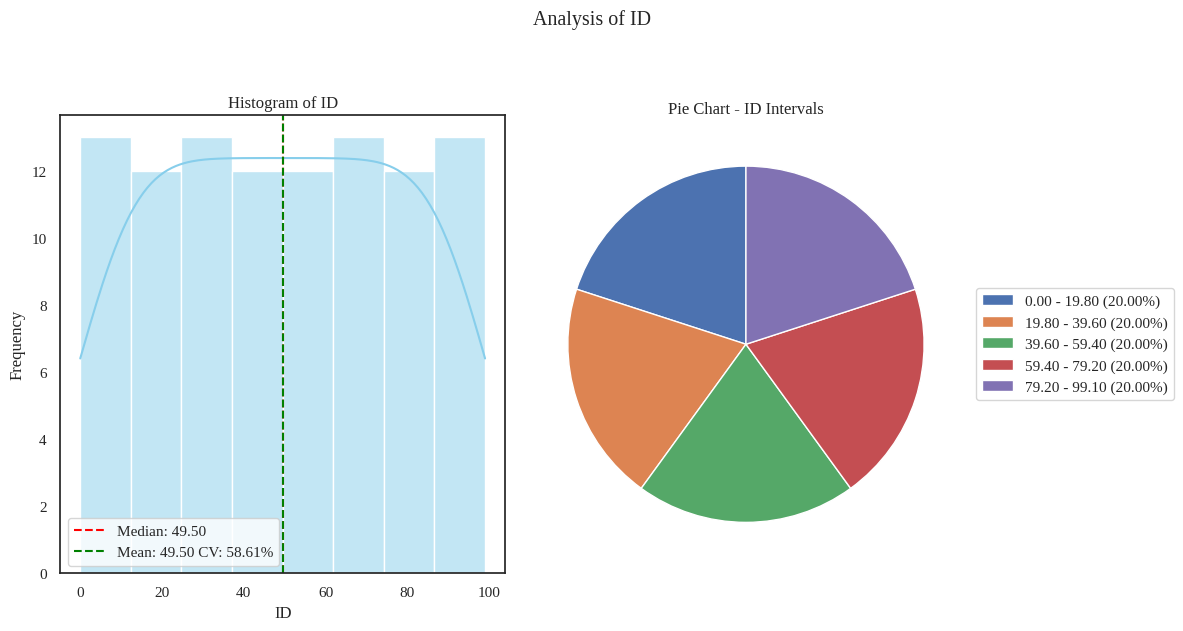

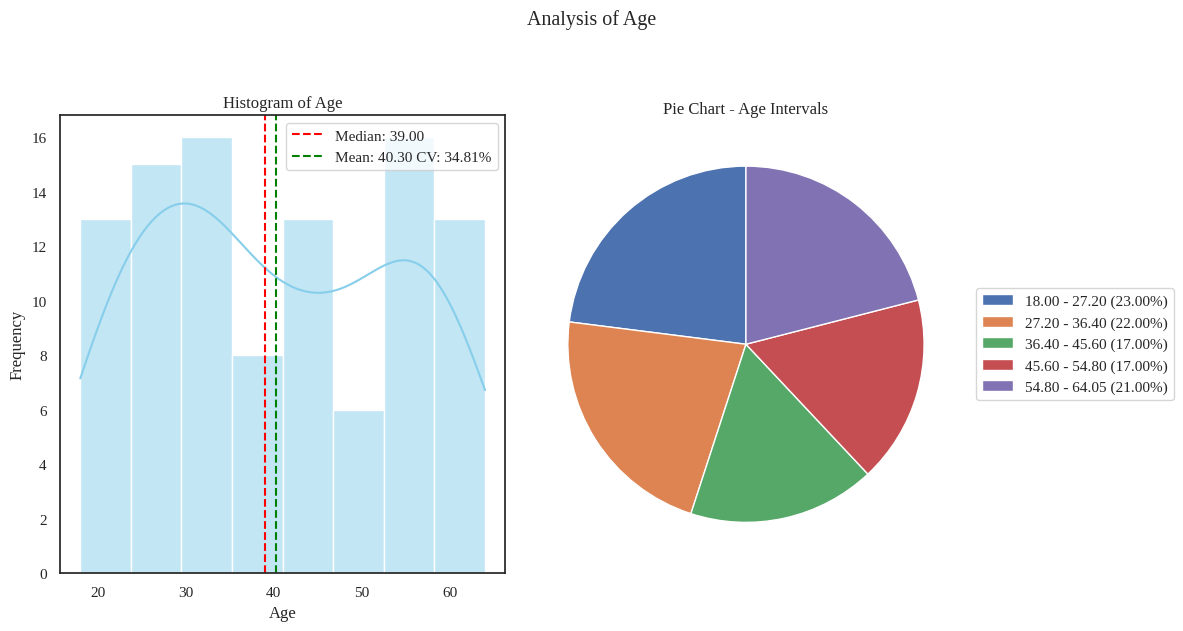

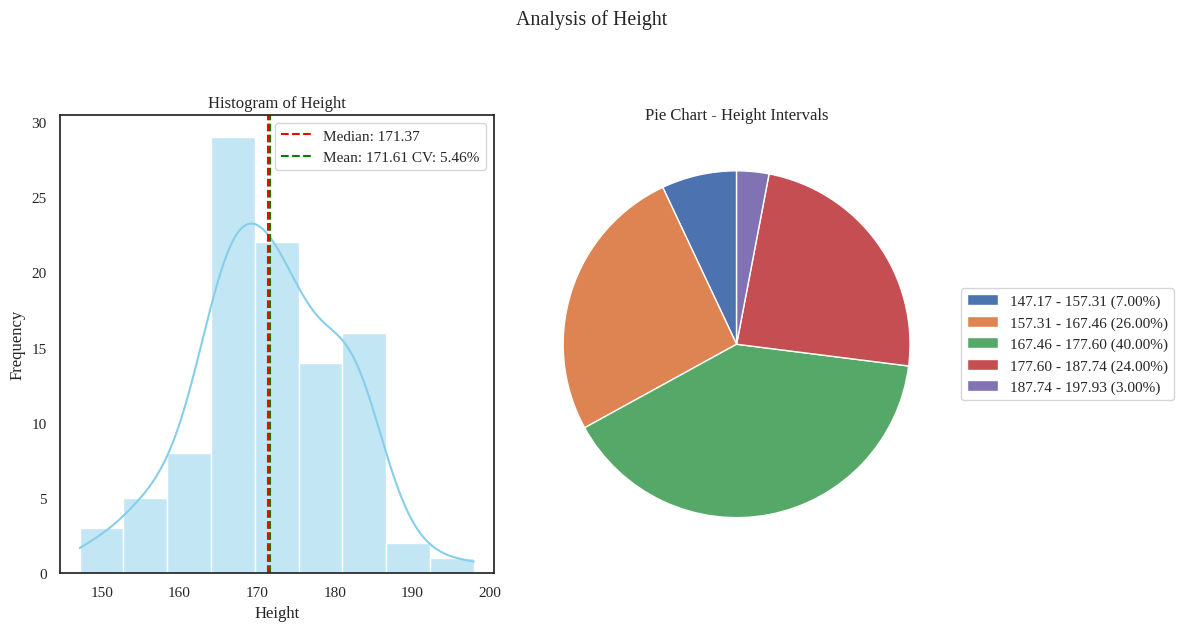

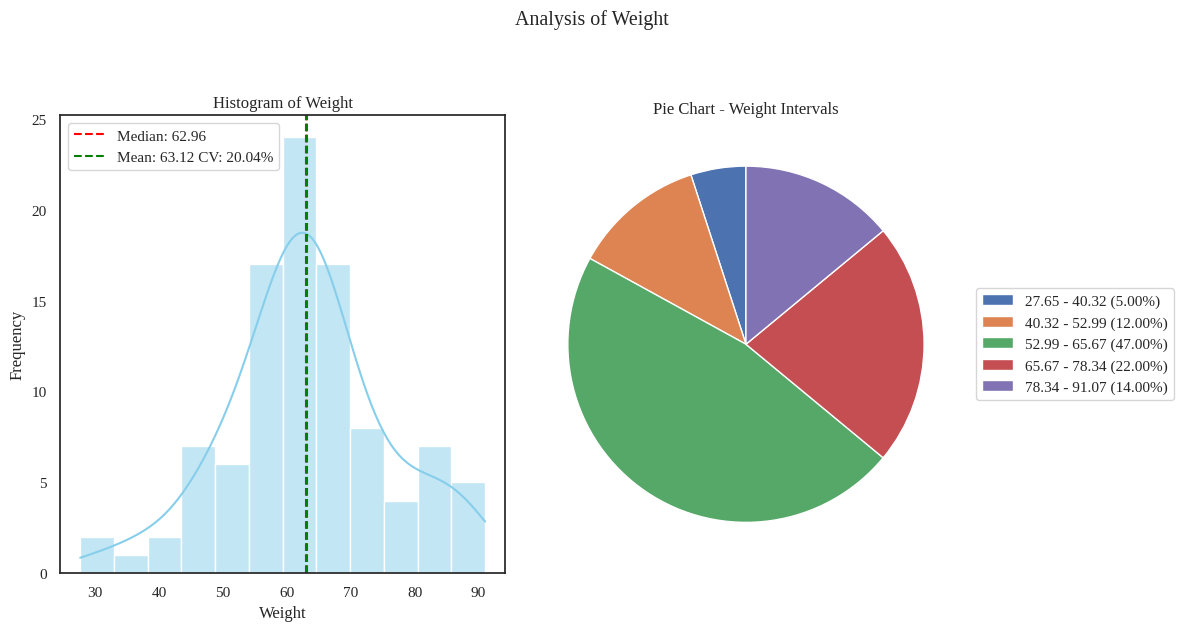

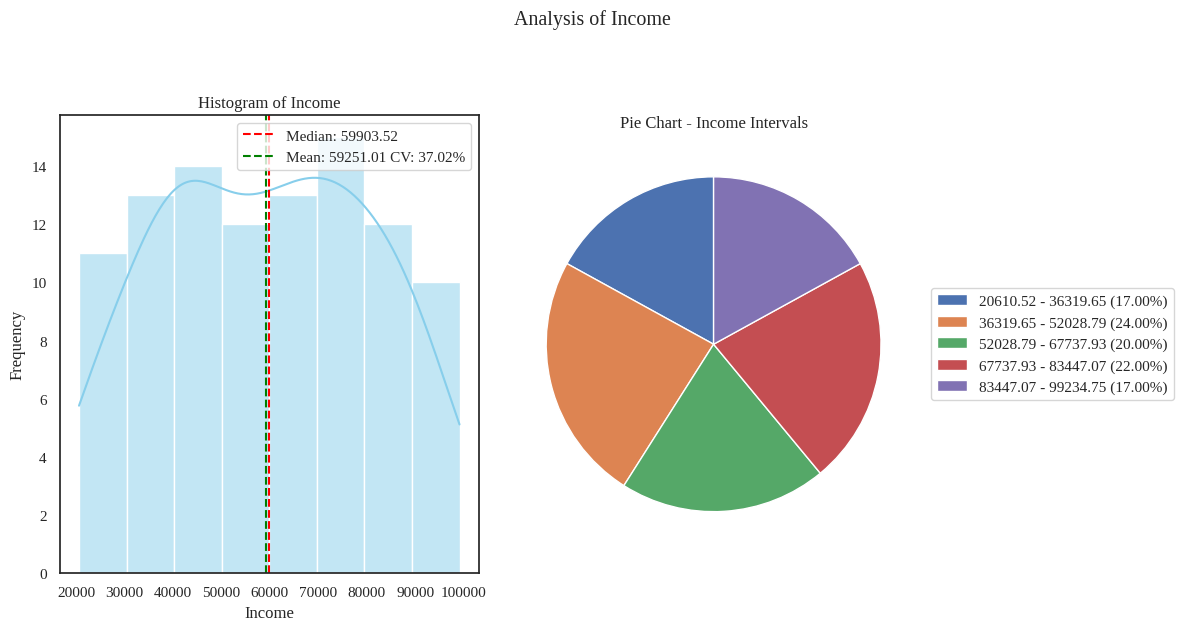

Categorical Variables:
Column: Category
Unique Values: ['B', 'C', 'A']
Categories (3, object): ['A', 'B', 'C']
Value Frequencies:
Category
C    38
A    34
B    28
Name: count, dtype: int64
Value Proportions:
Category
C    38.00%
A    34.00%
B    28.00%
Name: proportion, dtype: object



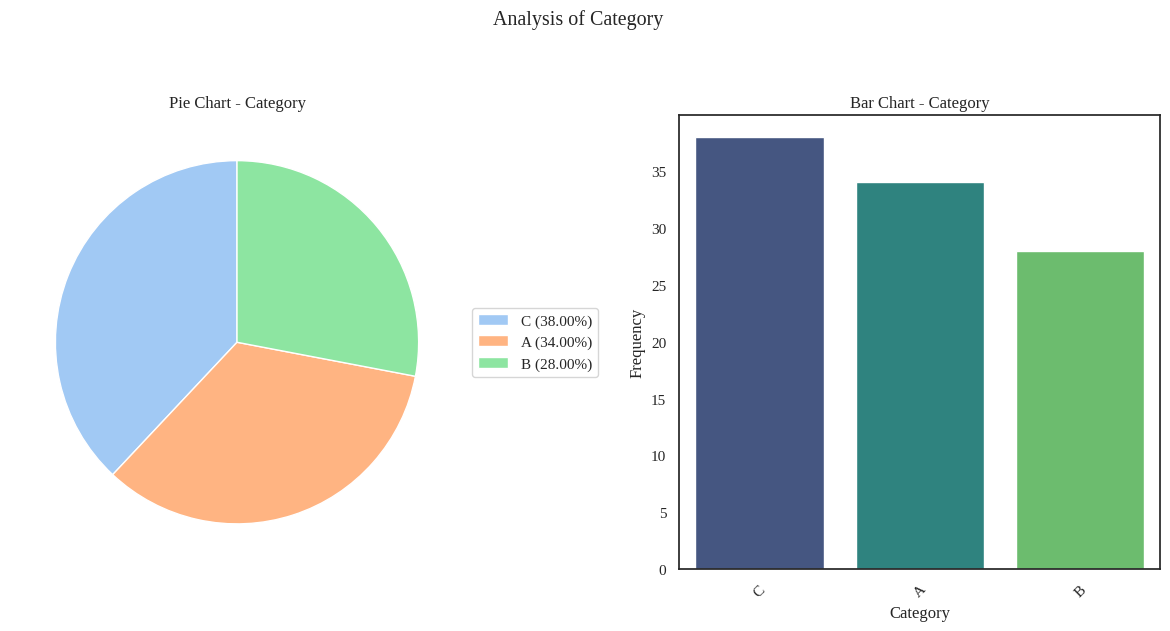

Column: Variable1
Unique Values: ['X', 'Z', 'Y']
Categories (3, object): ['X', 'Y', 'Z']
Value Frequencies:
Variable1
X    34
Y    34
Z    32
Name: count, dtype: int64
Value Proportions:
Variable1
X    34.00%
Y    34.00%
Z    32.00%
Name: proportion, dtype: object



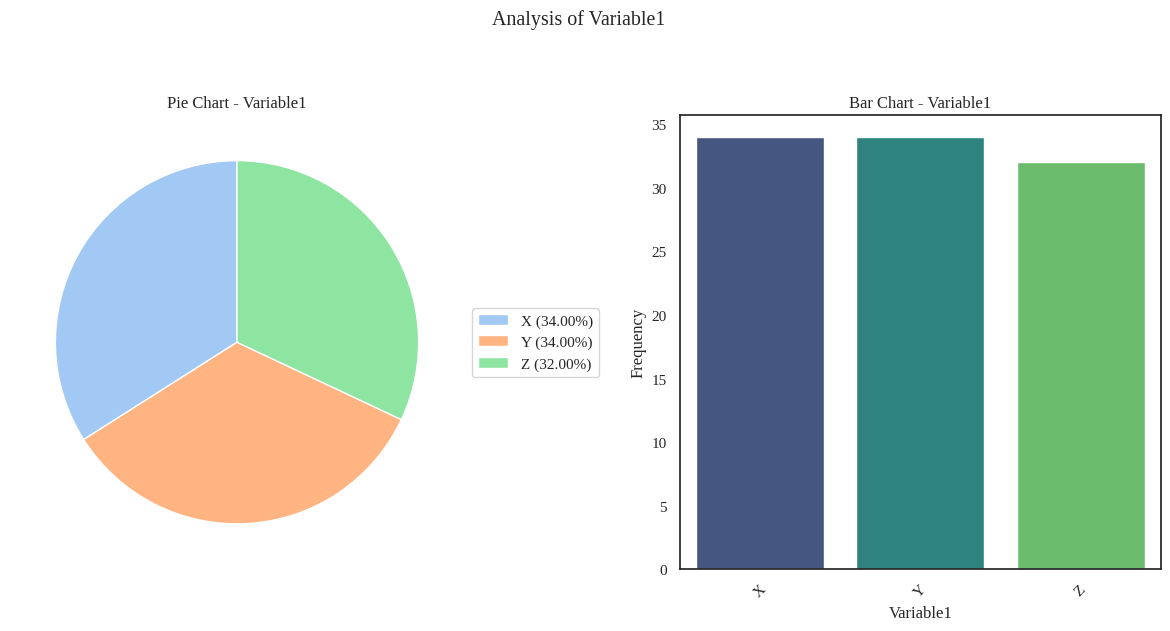

Column: Variable2
Unique Values: ['P', 'R', 'Q']
Categories (3, object): ['P', 'Q', 'R']
Value Frequencies:
Variable2
Q    40
P    32
R    28
Name: count, dtype: int64
Value Proportions:
Variable2
Q    40.00%
P    32.00%
R    28.00%
Name: proportion, dtype: object



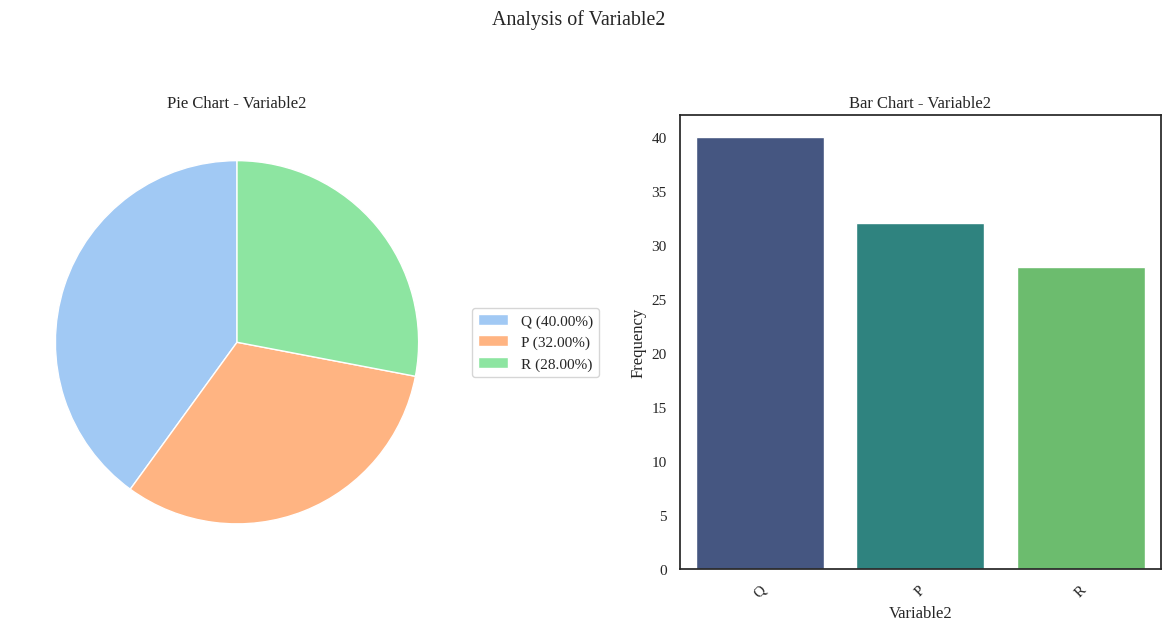

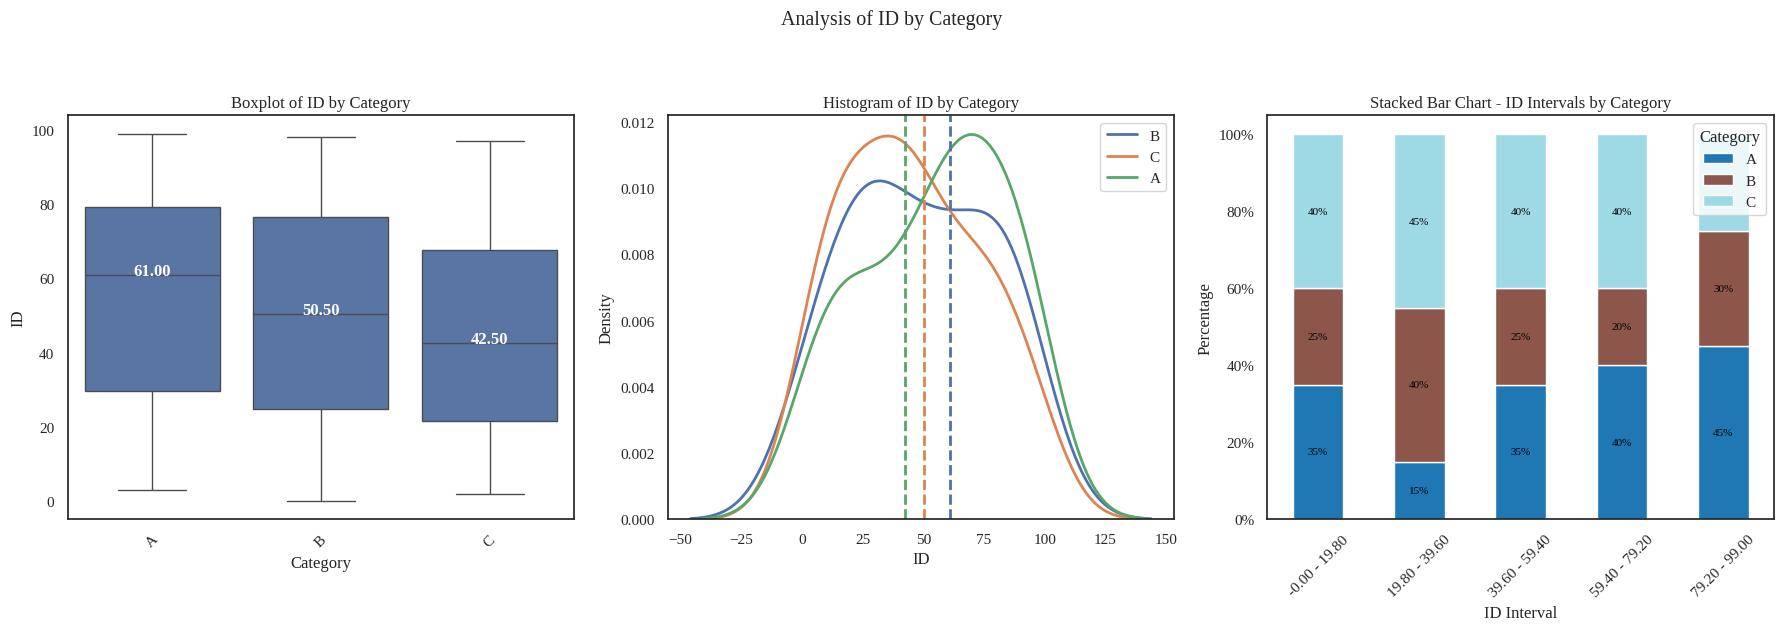

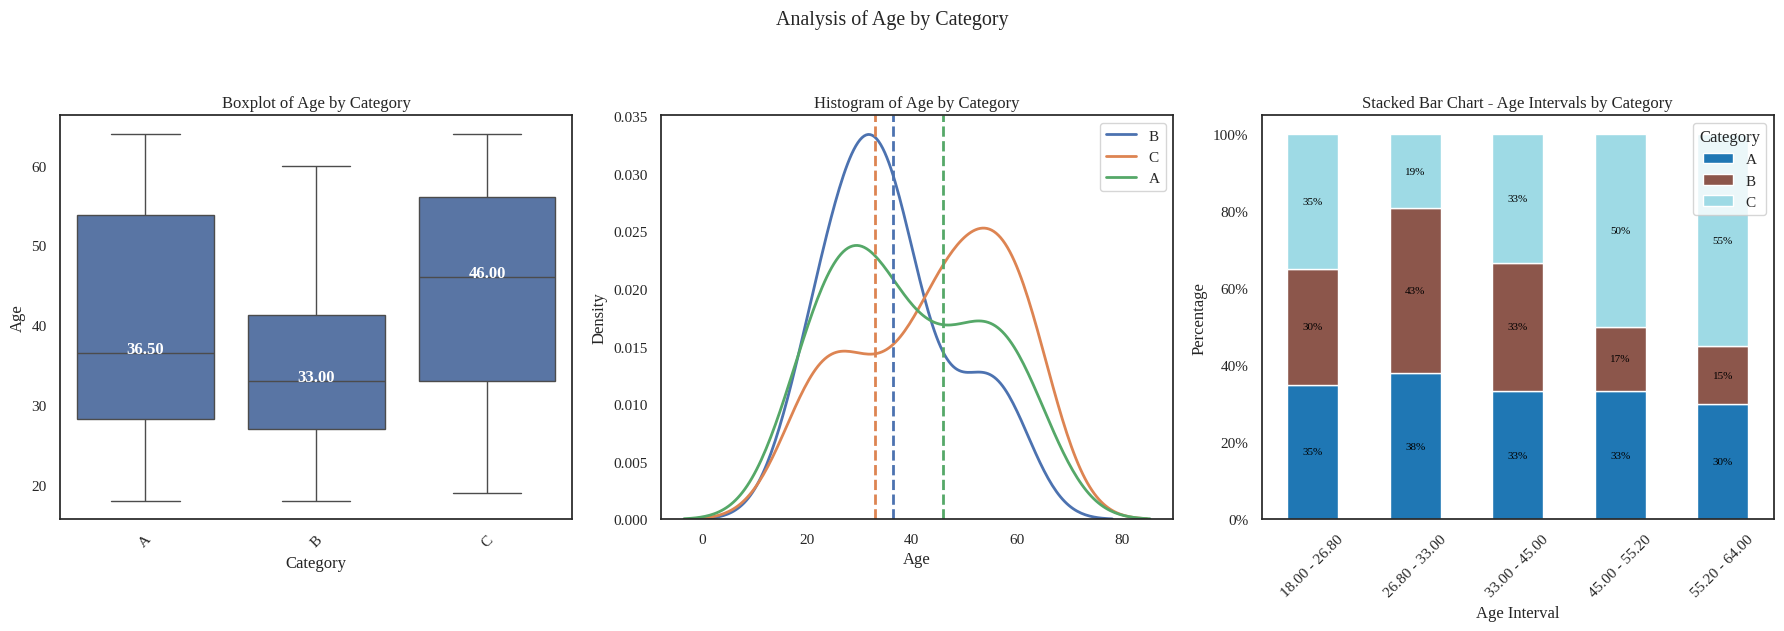

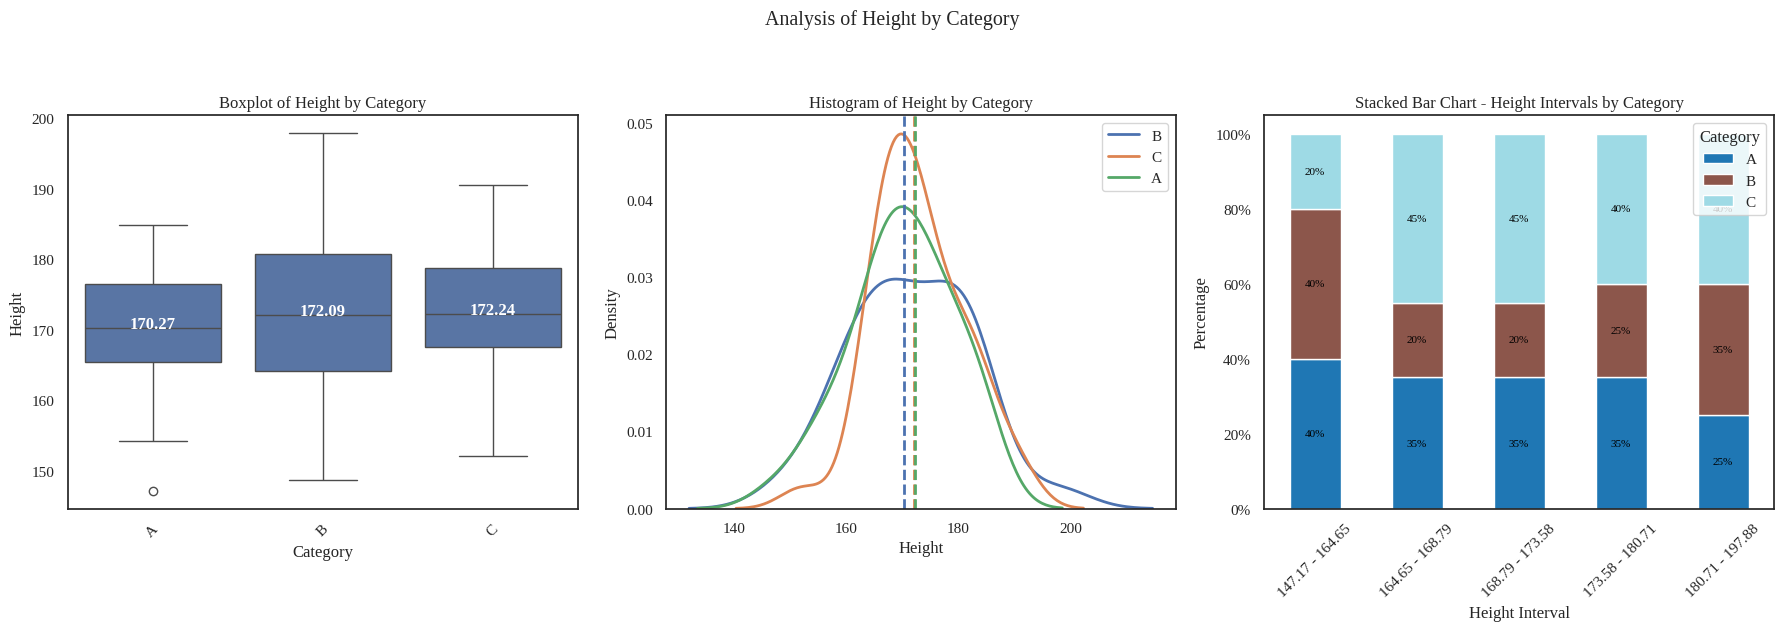

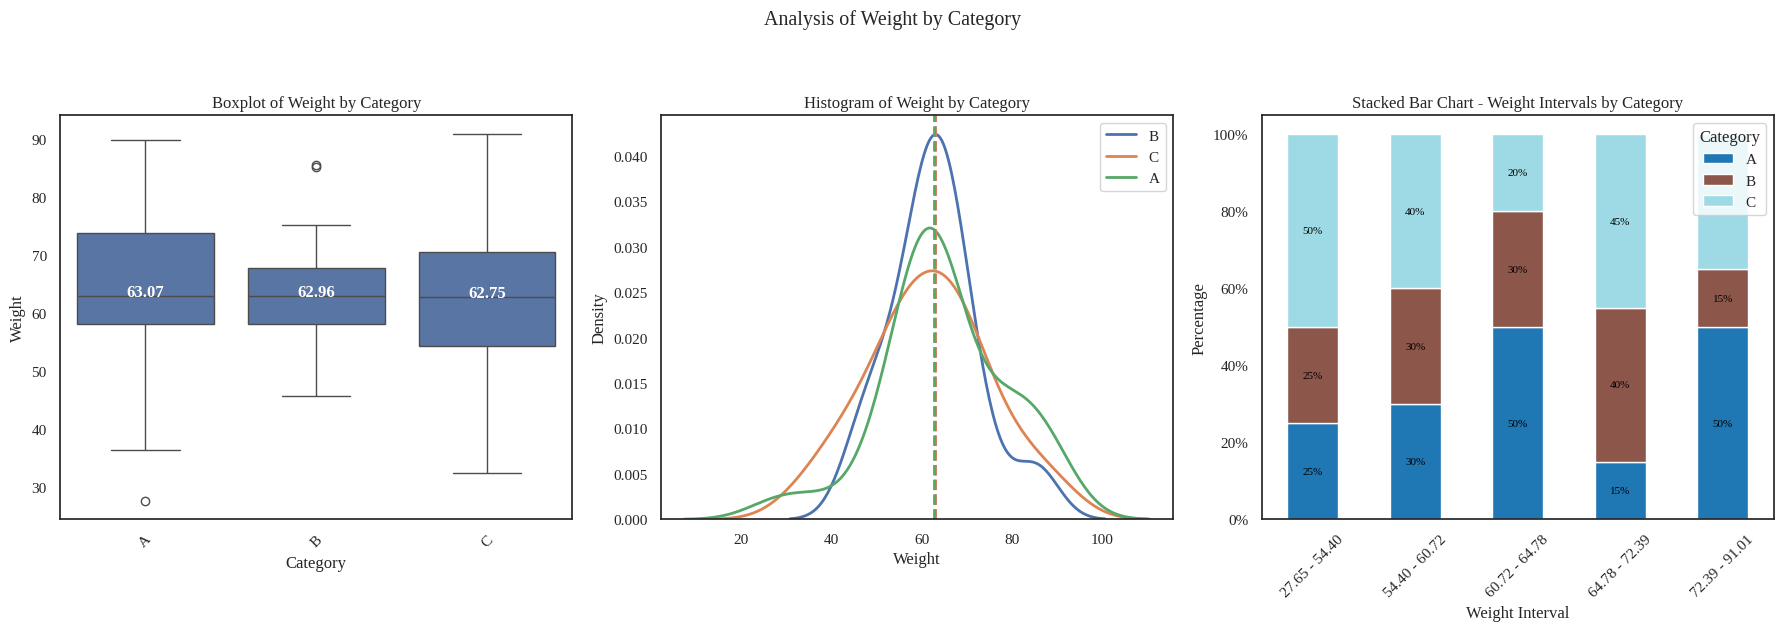

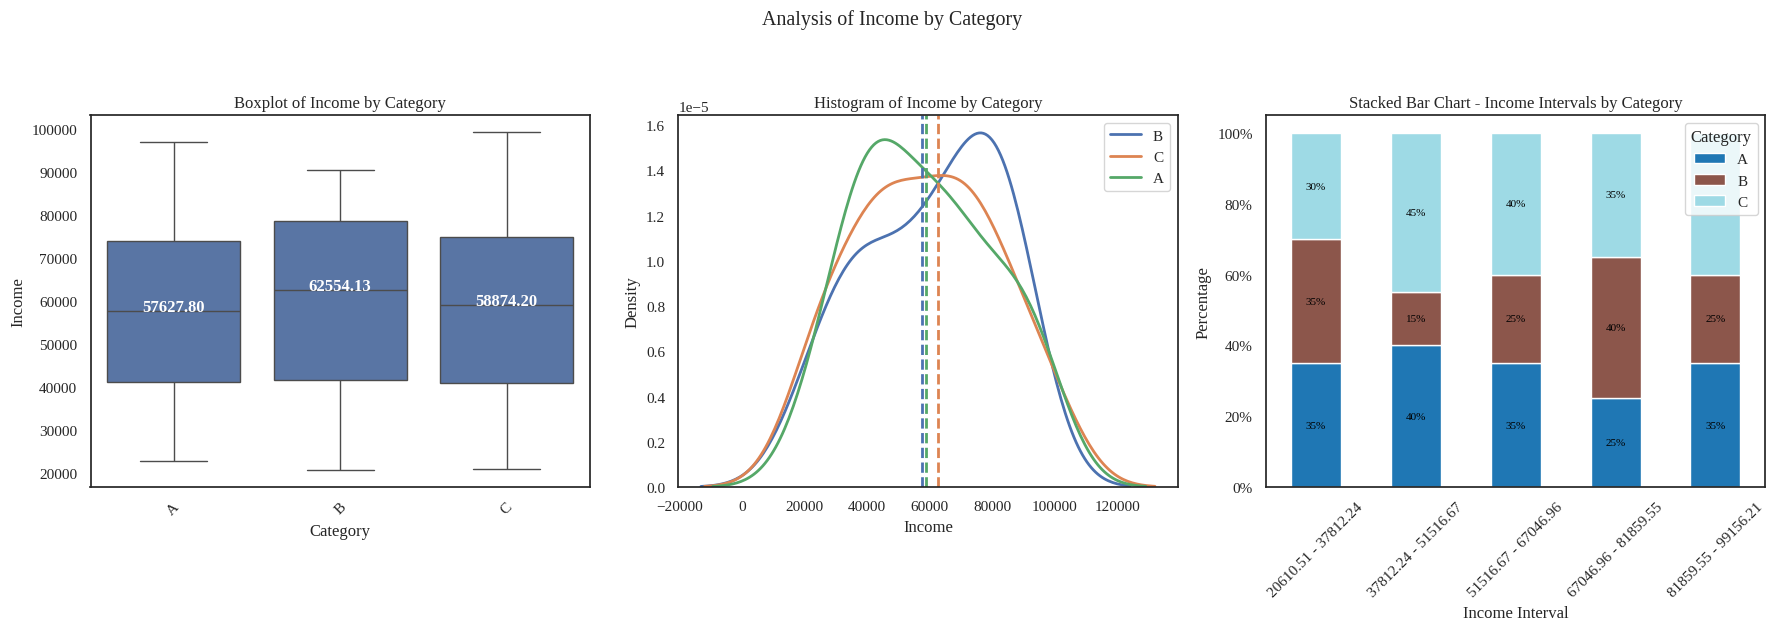

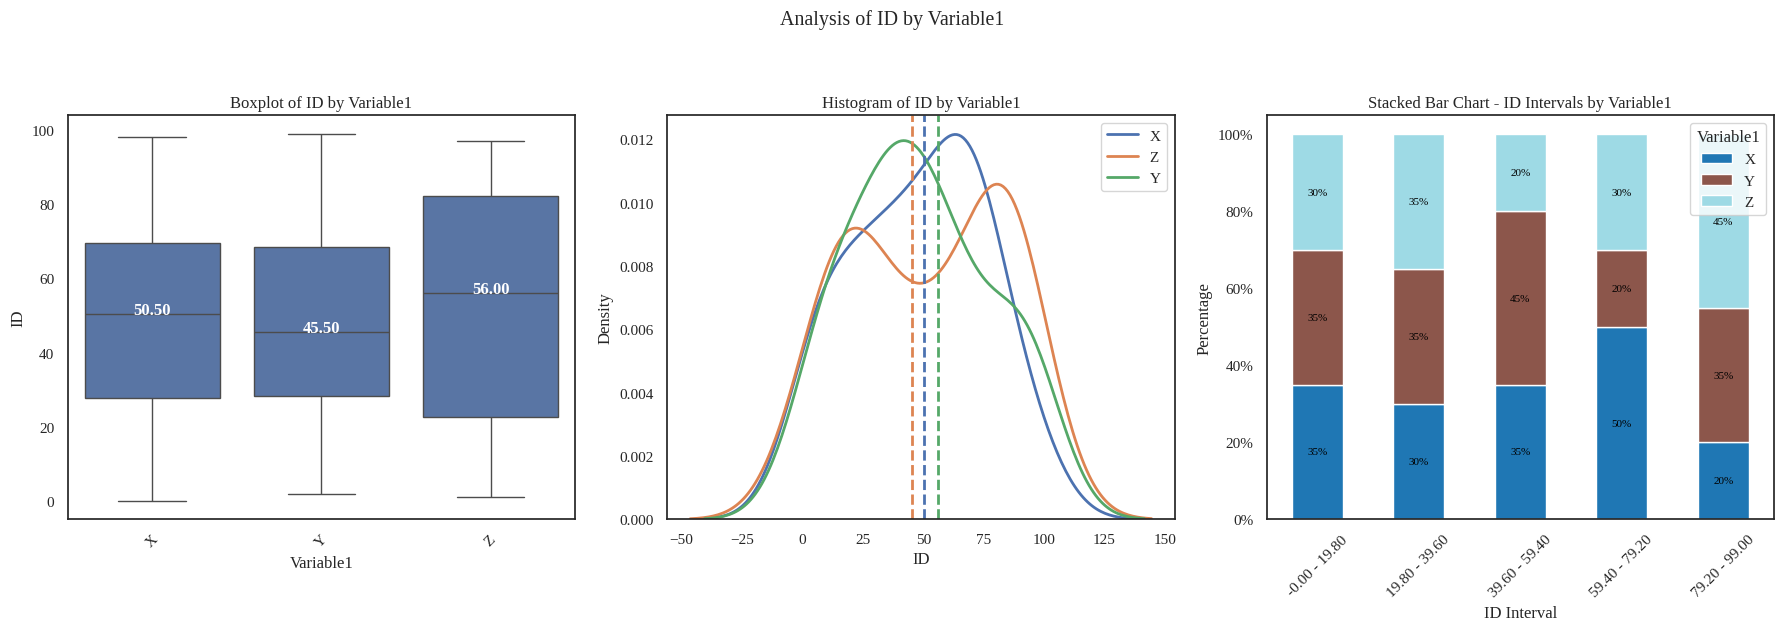

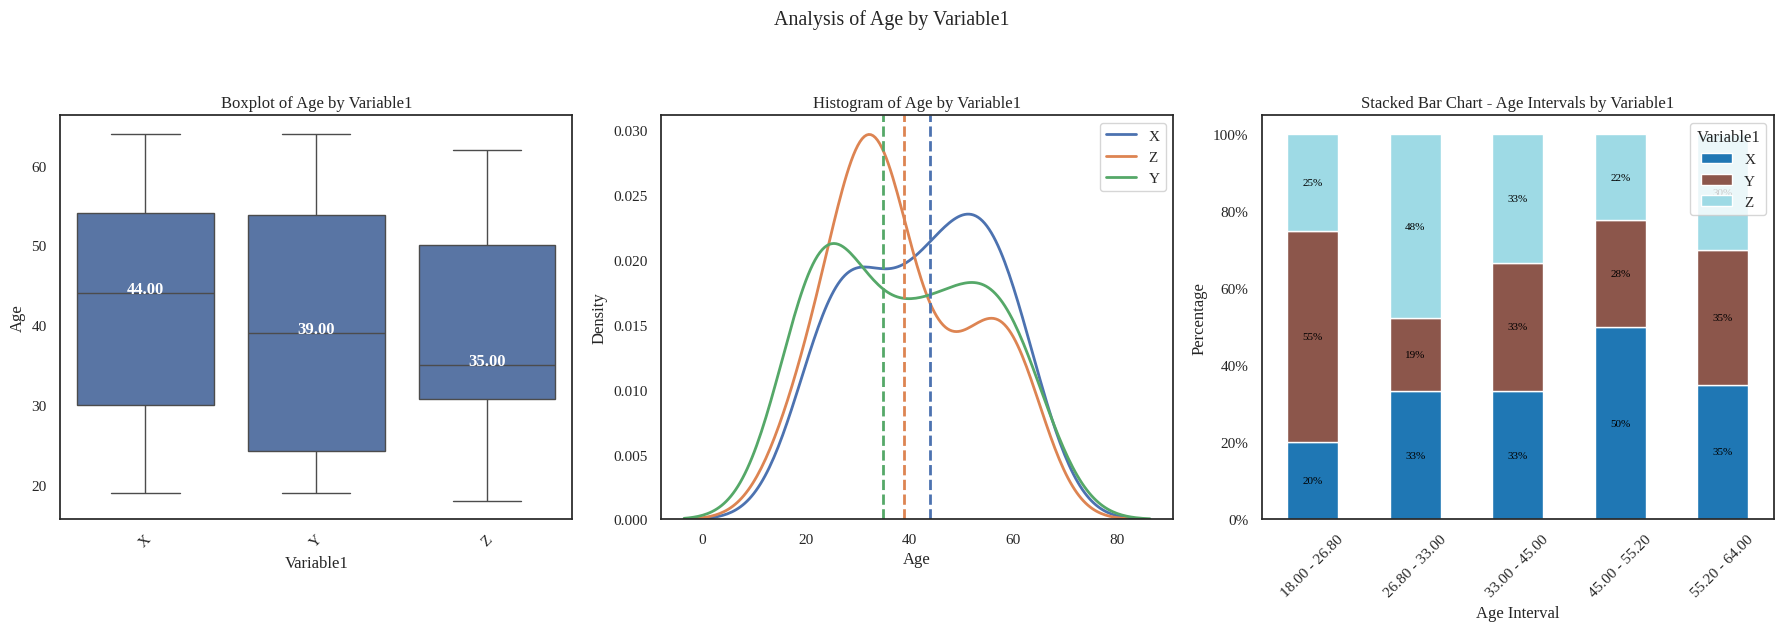

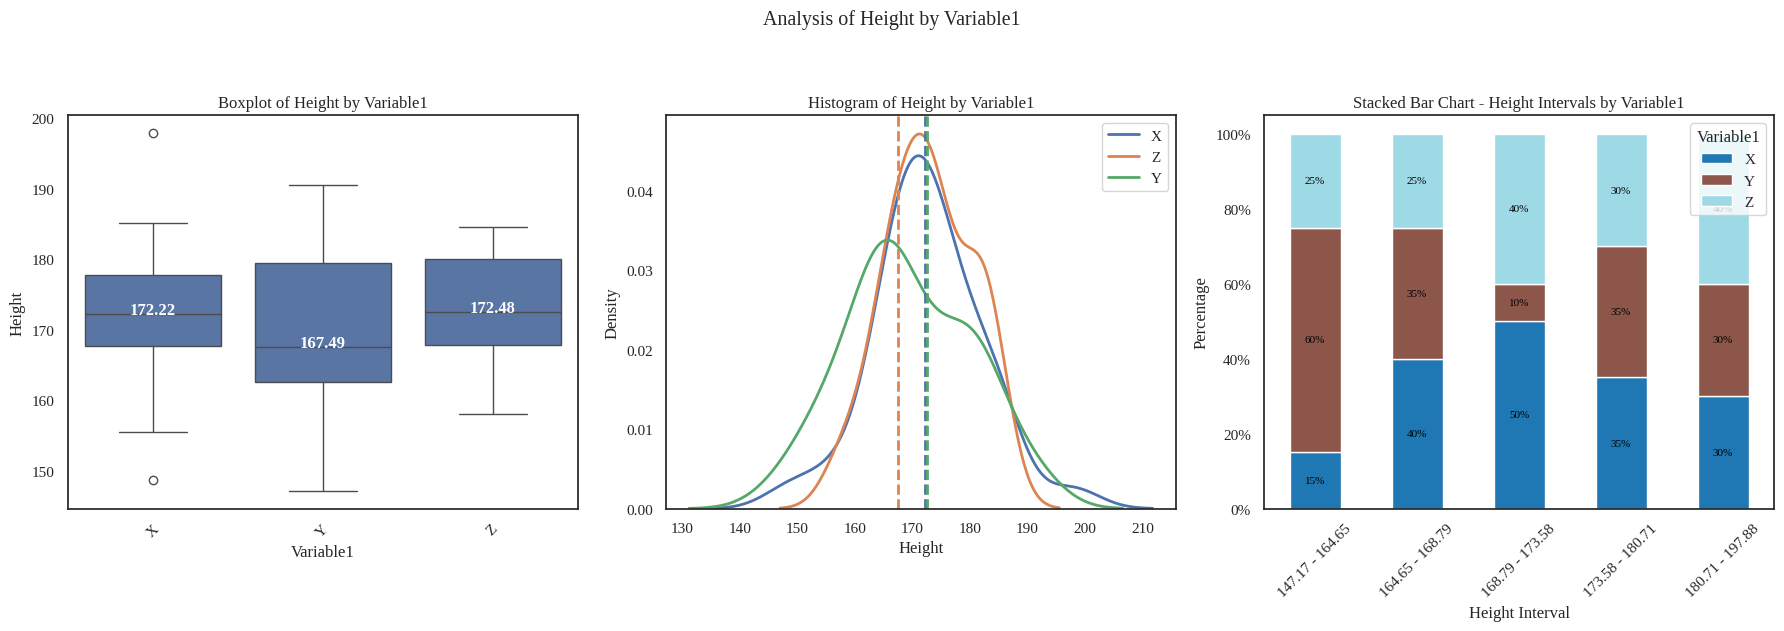

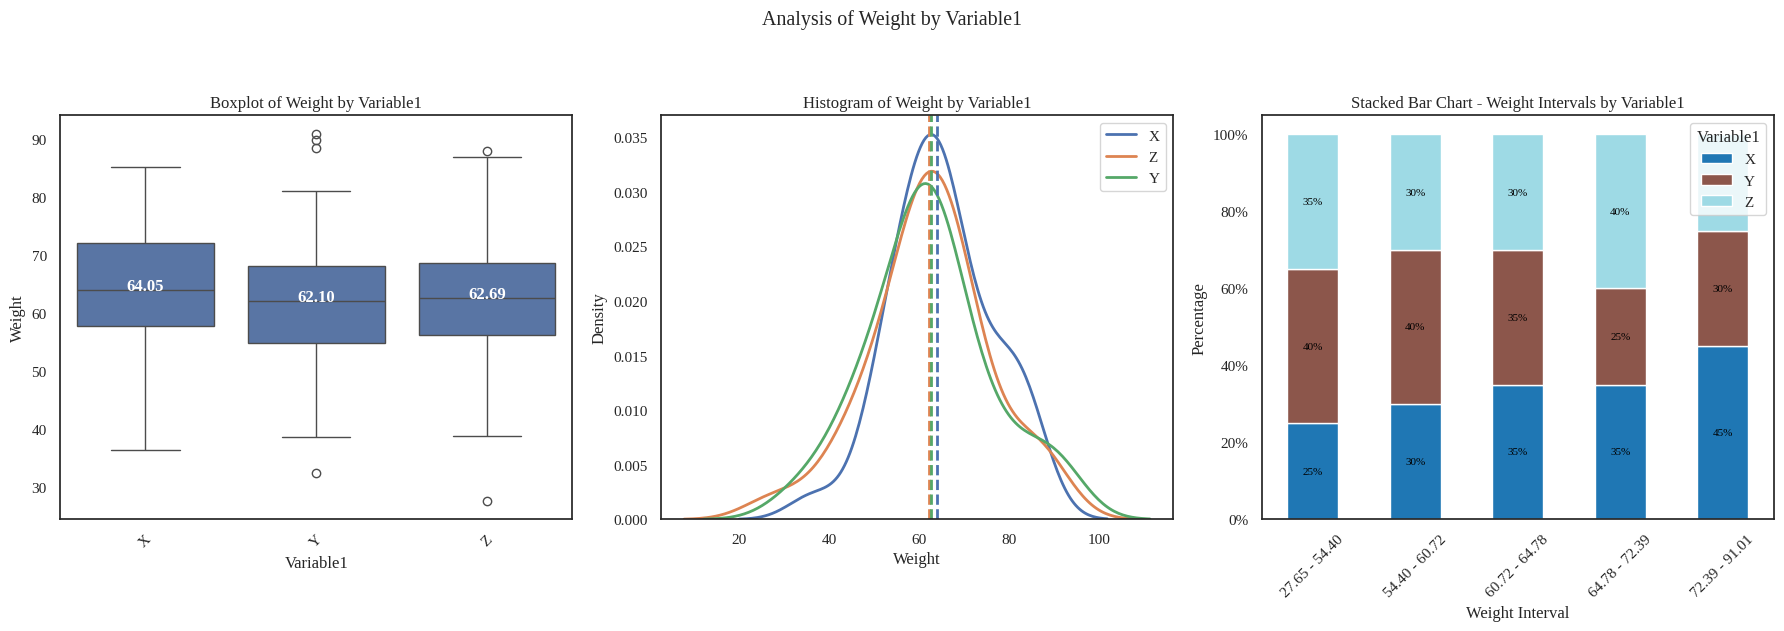

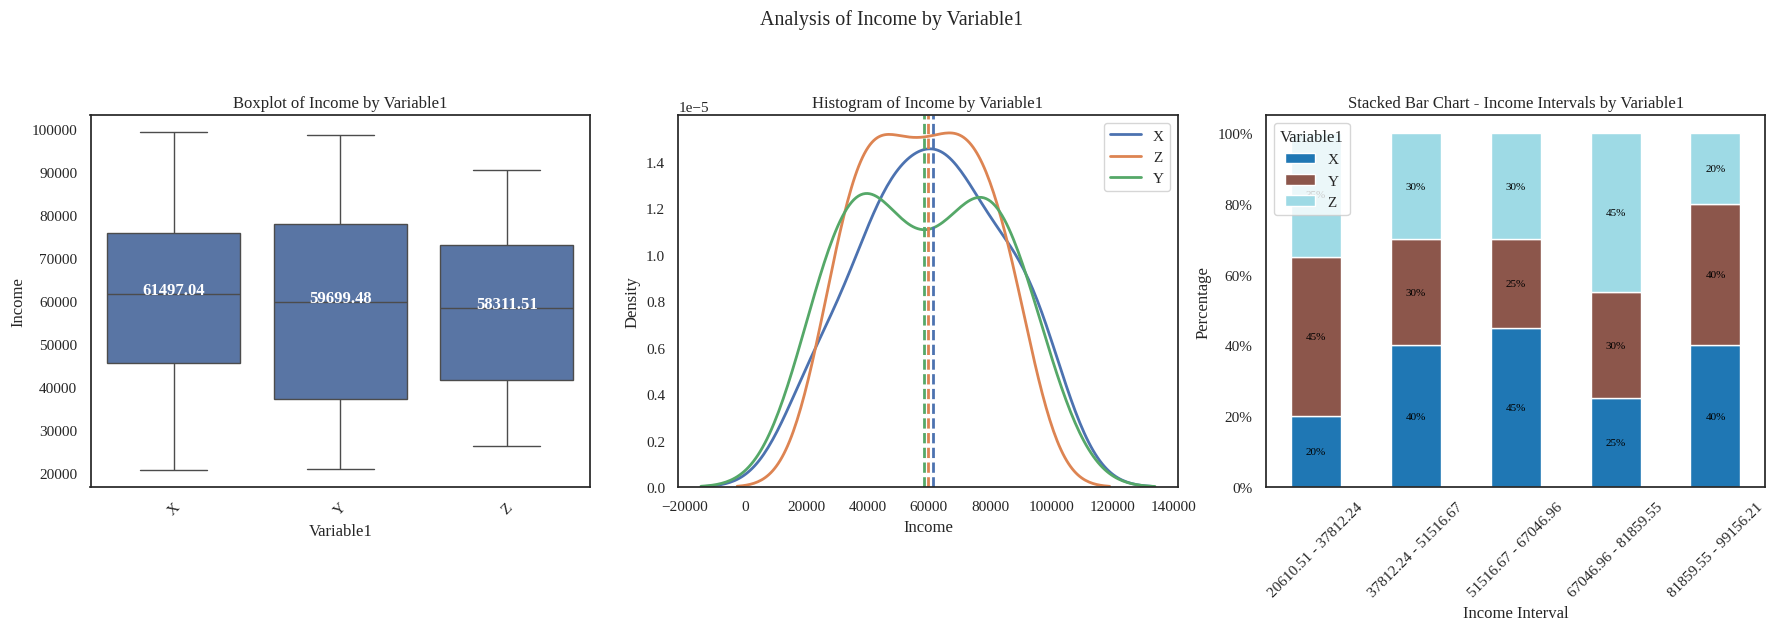

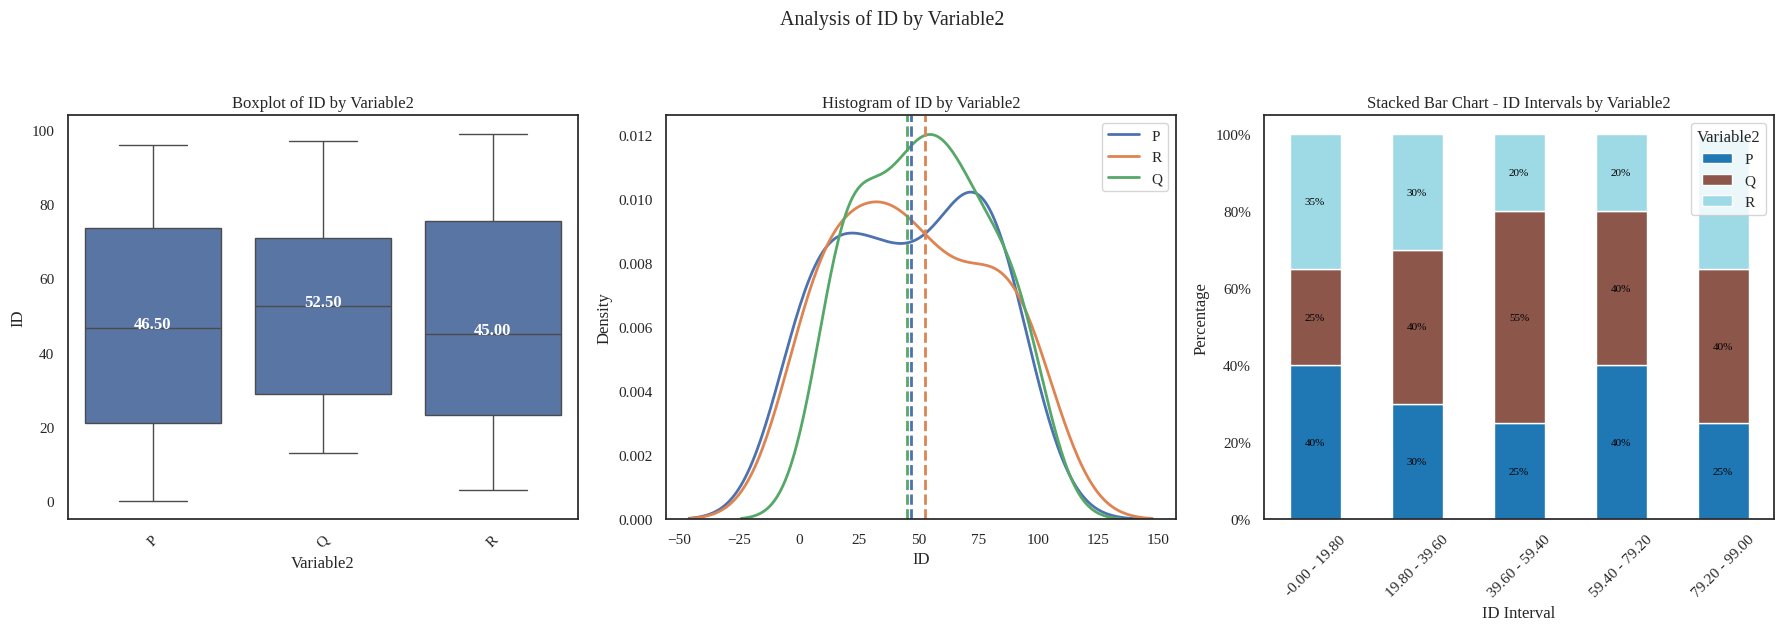

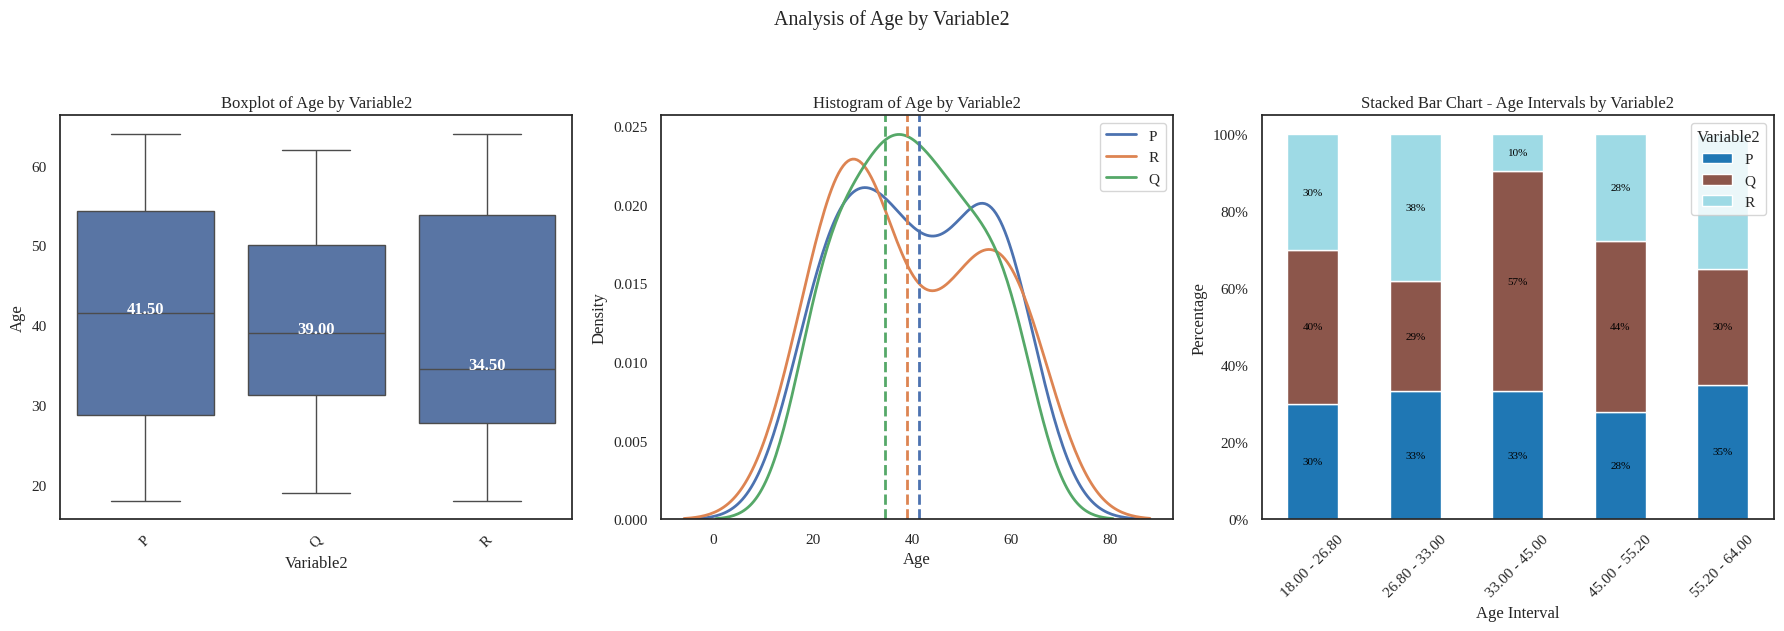

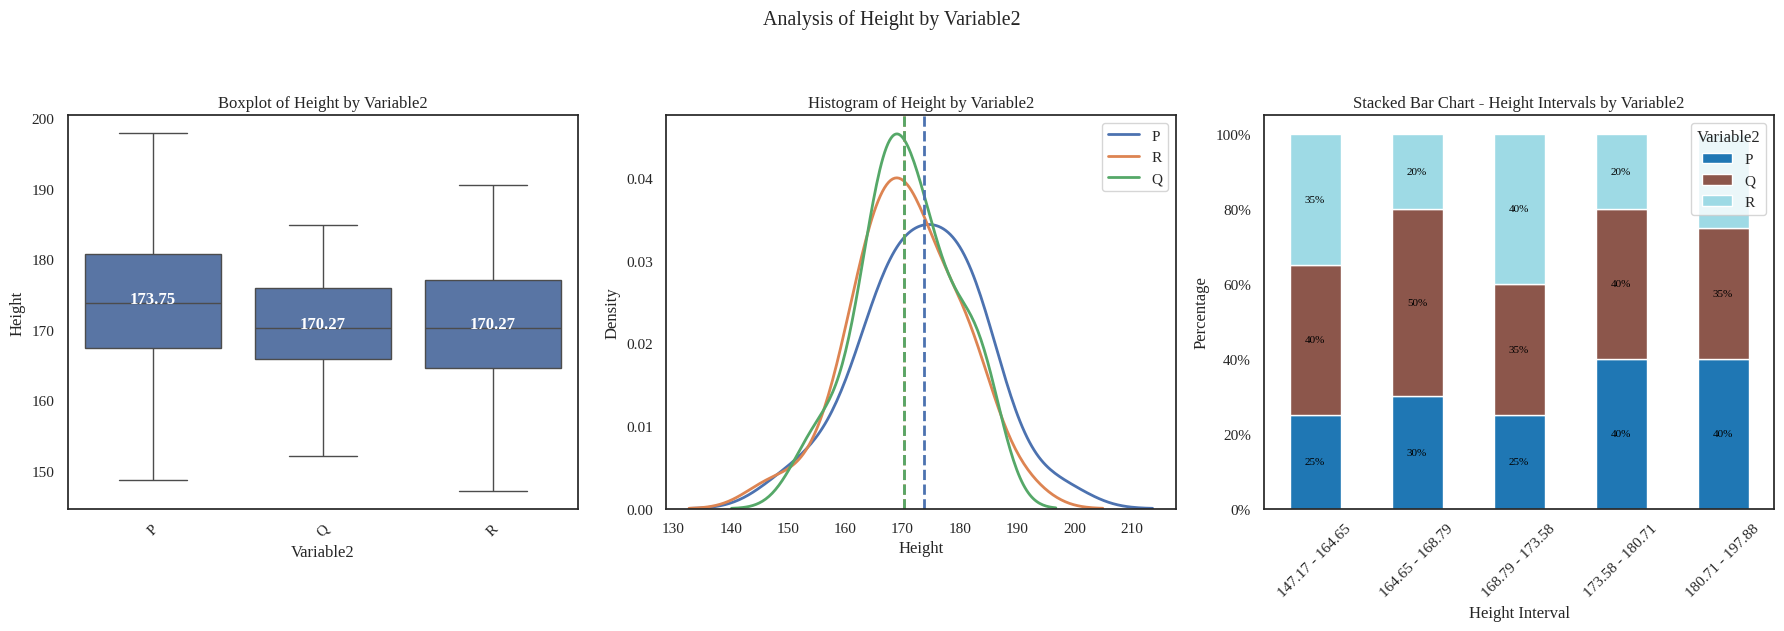

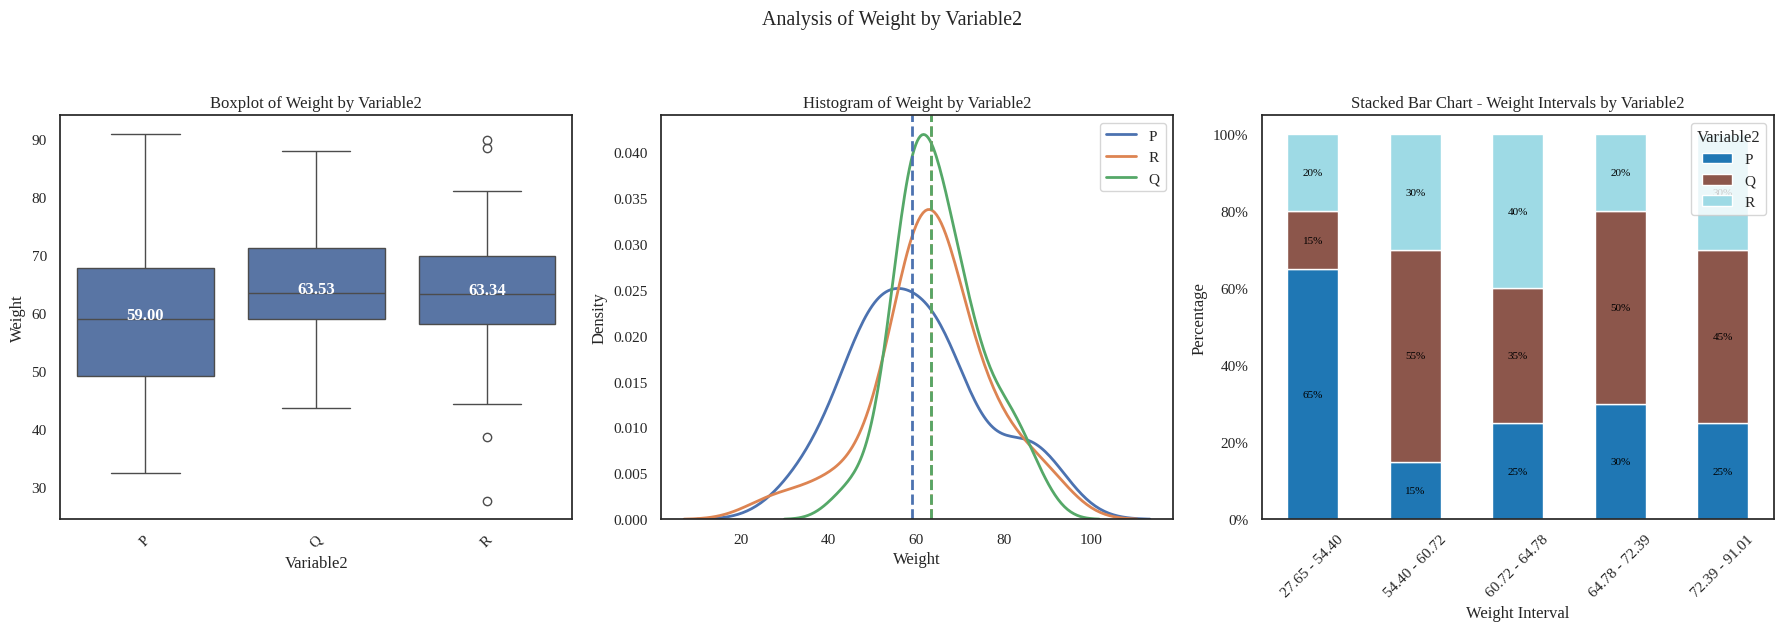

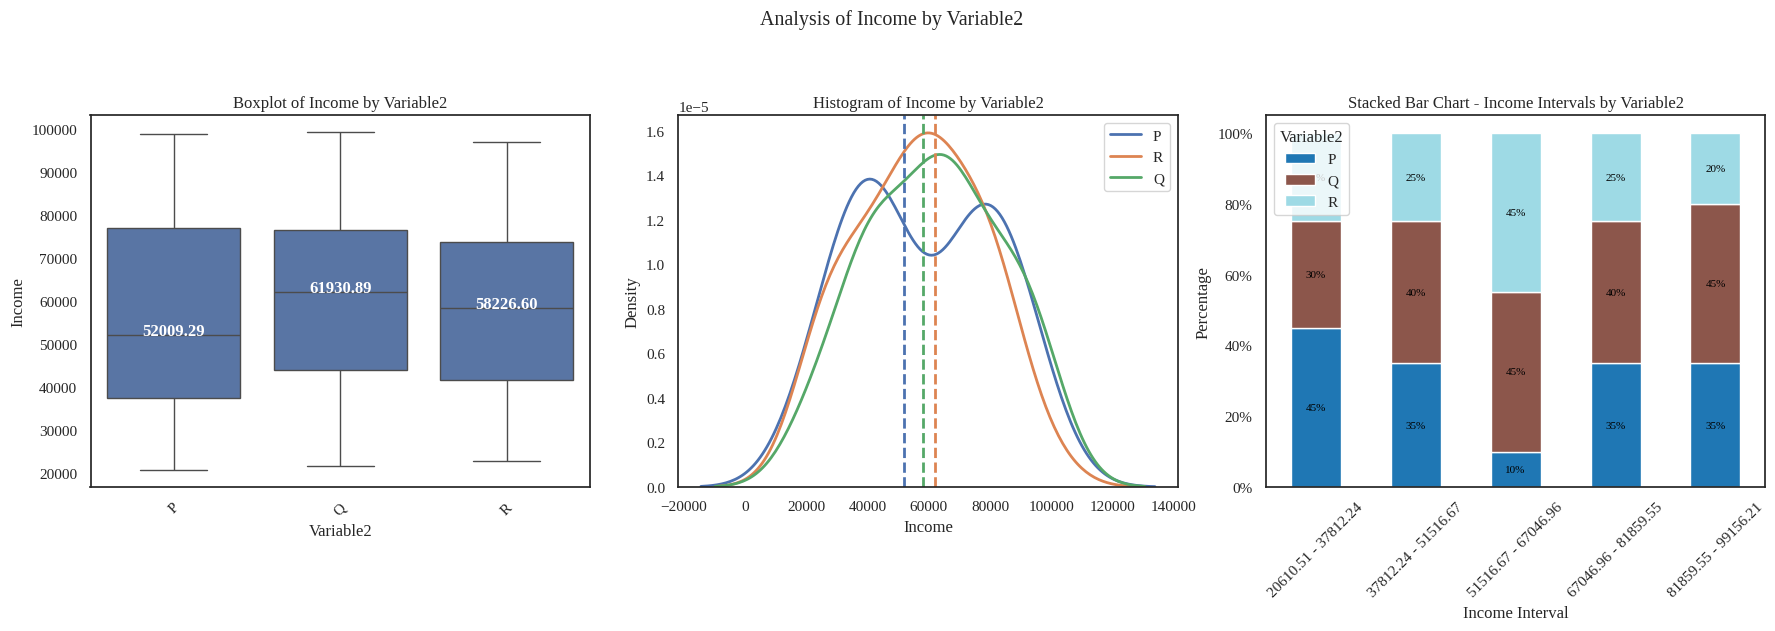

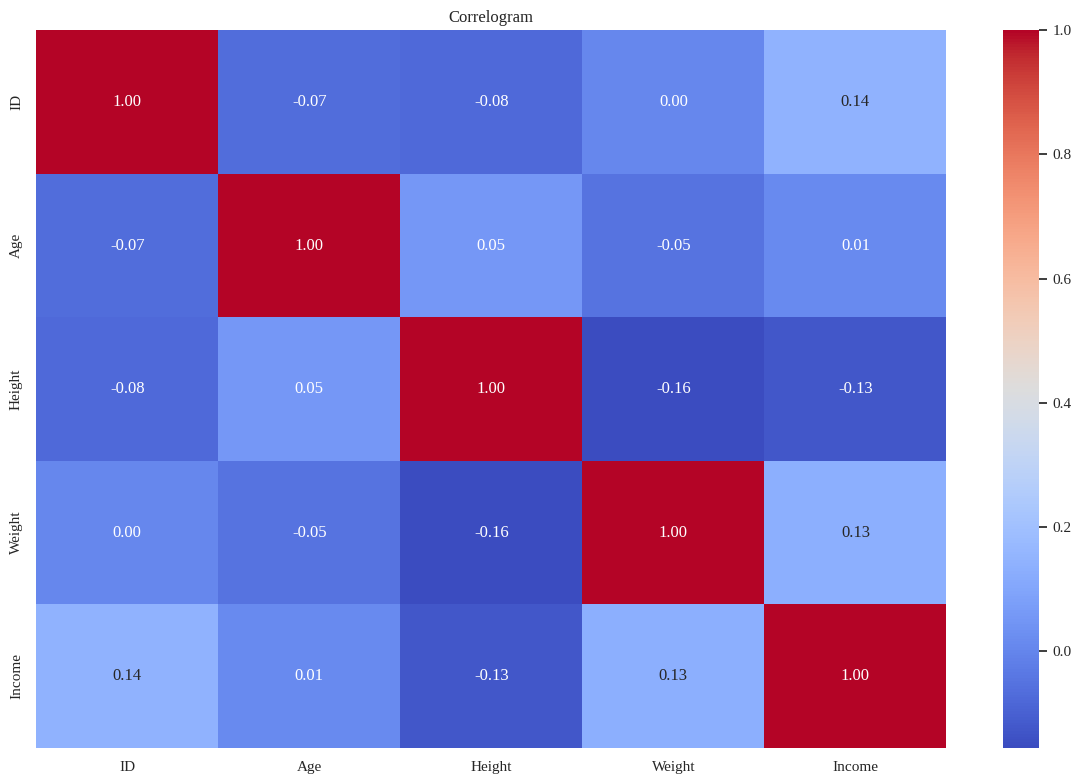

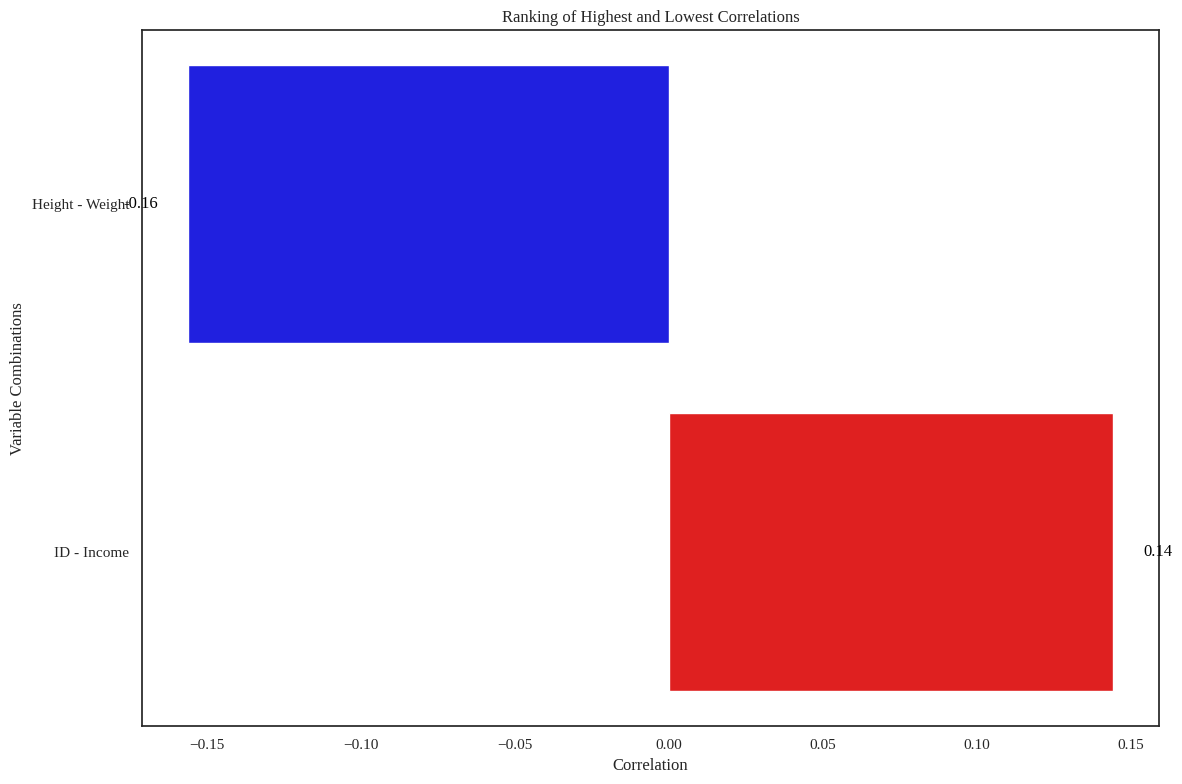

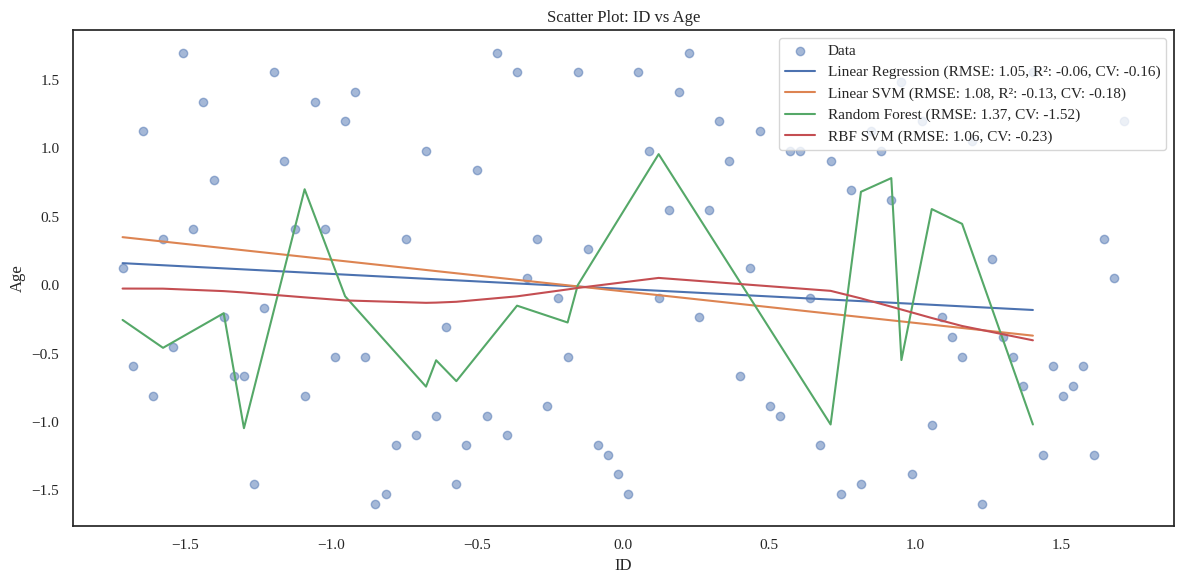

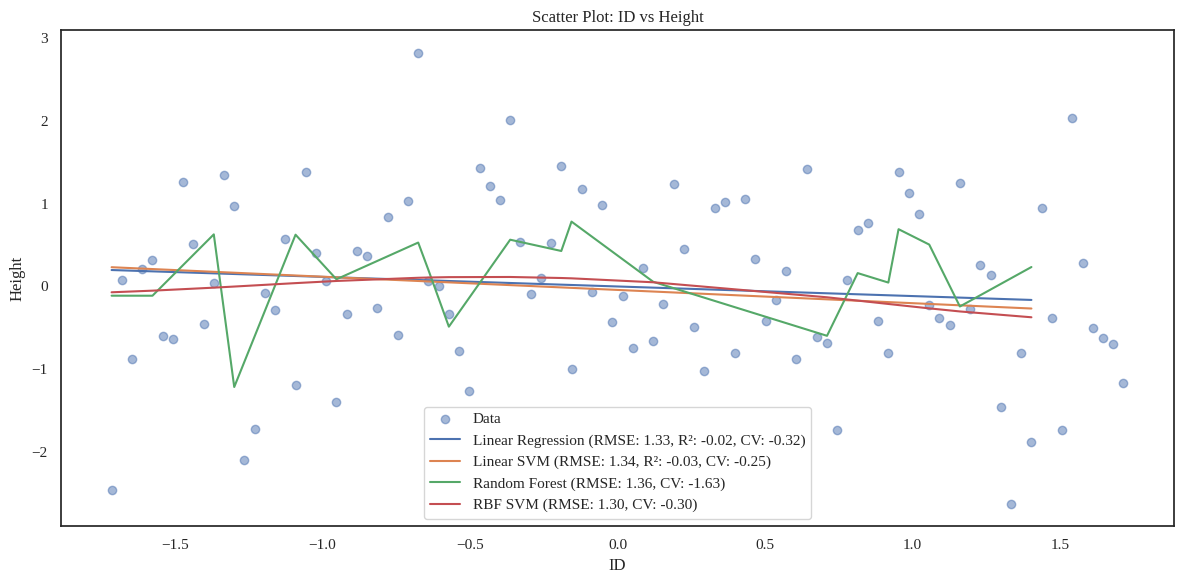

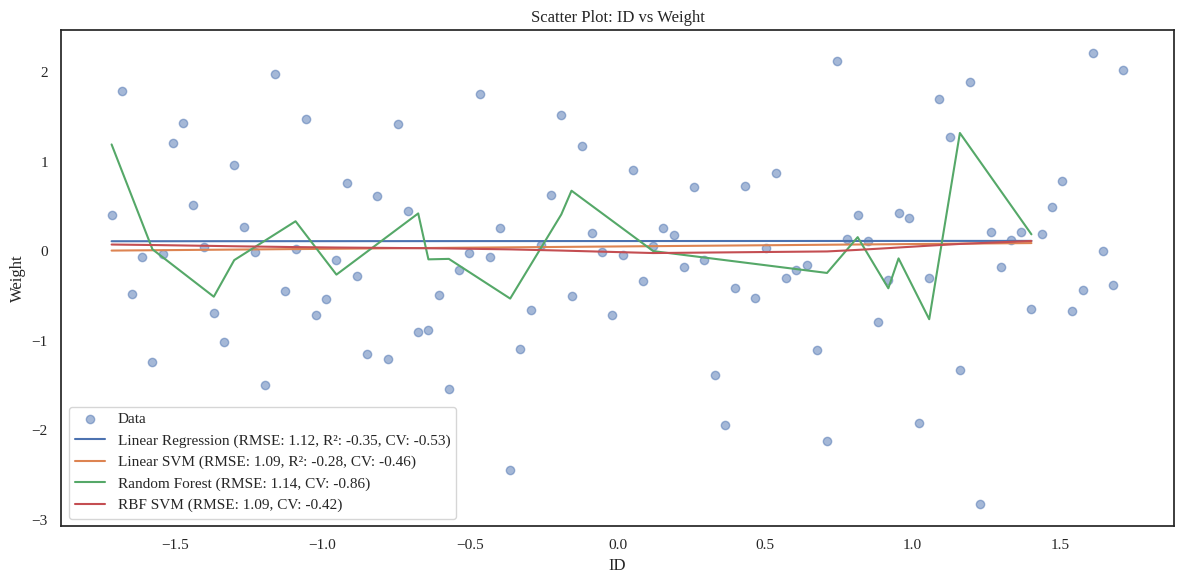

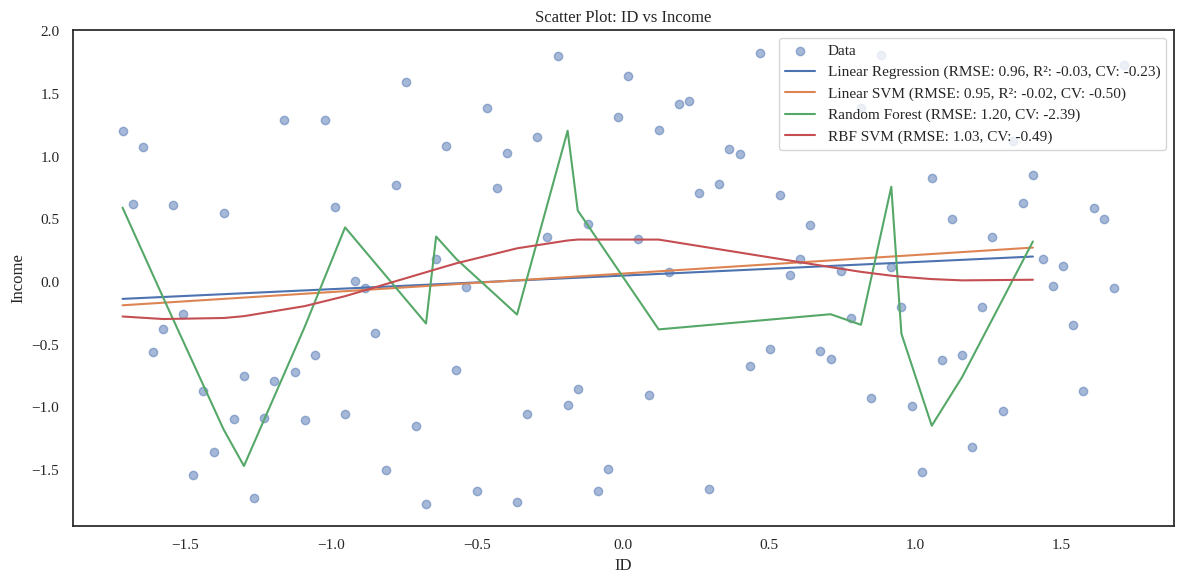

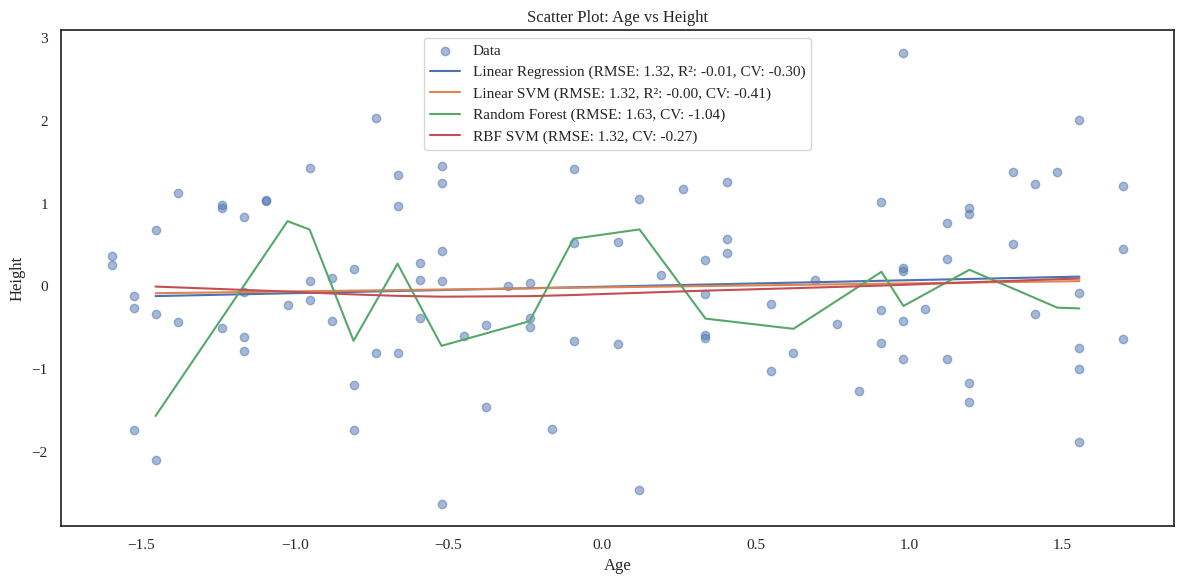

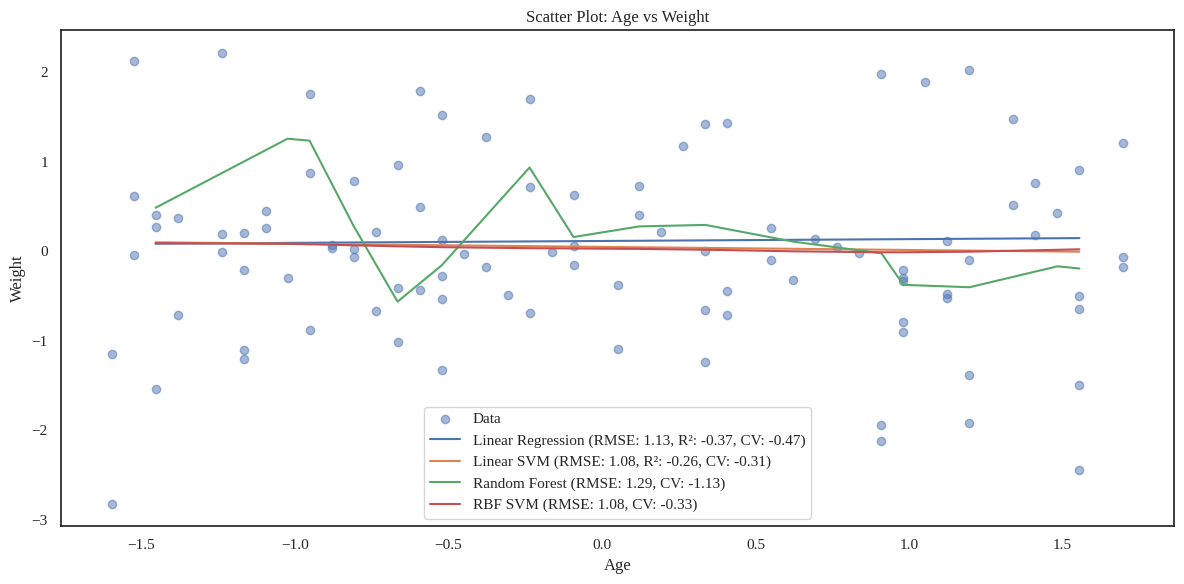

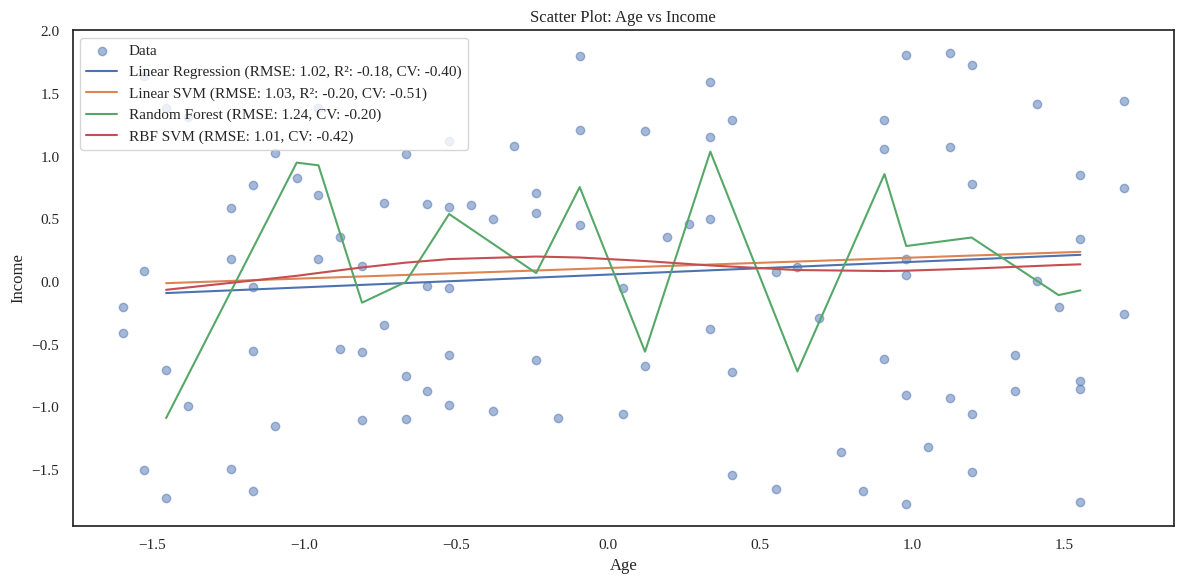

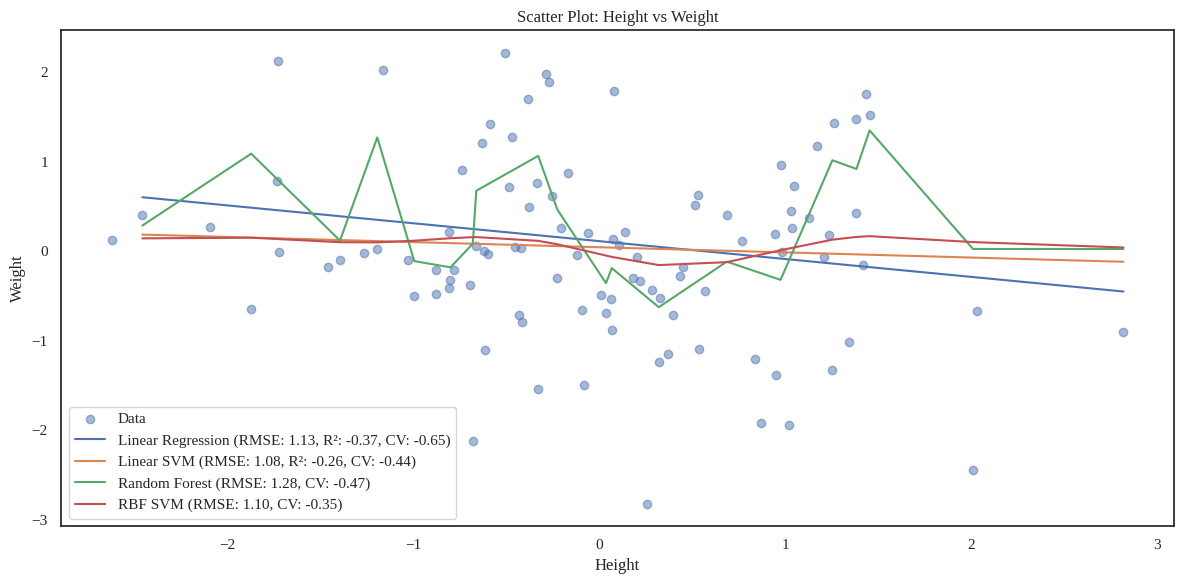

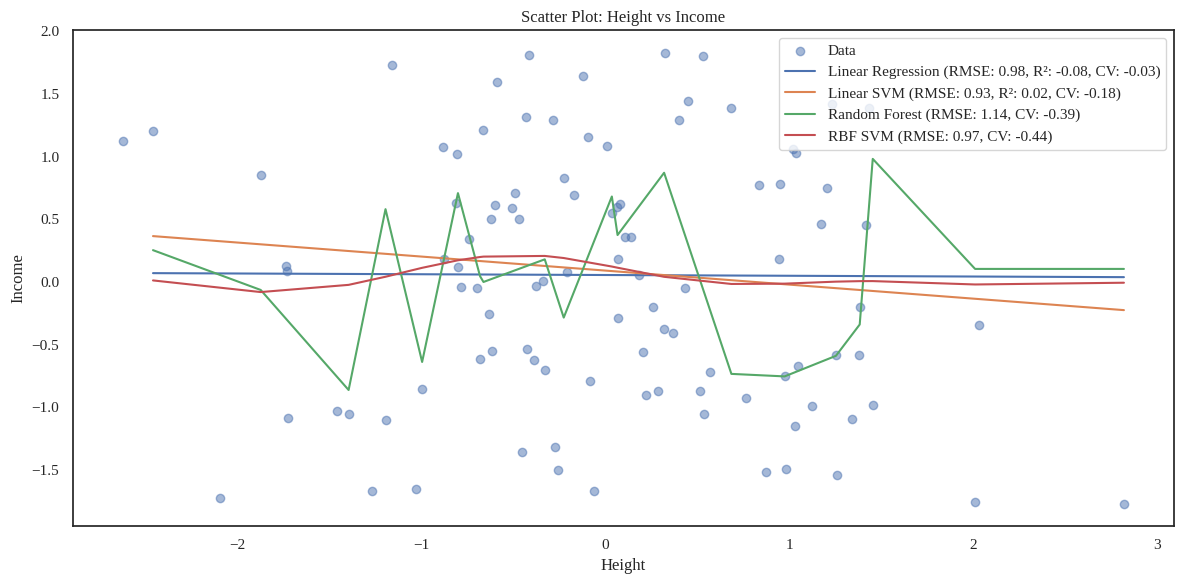

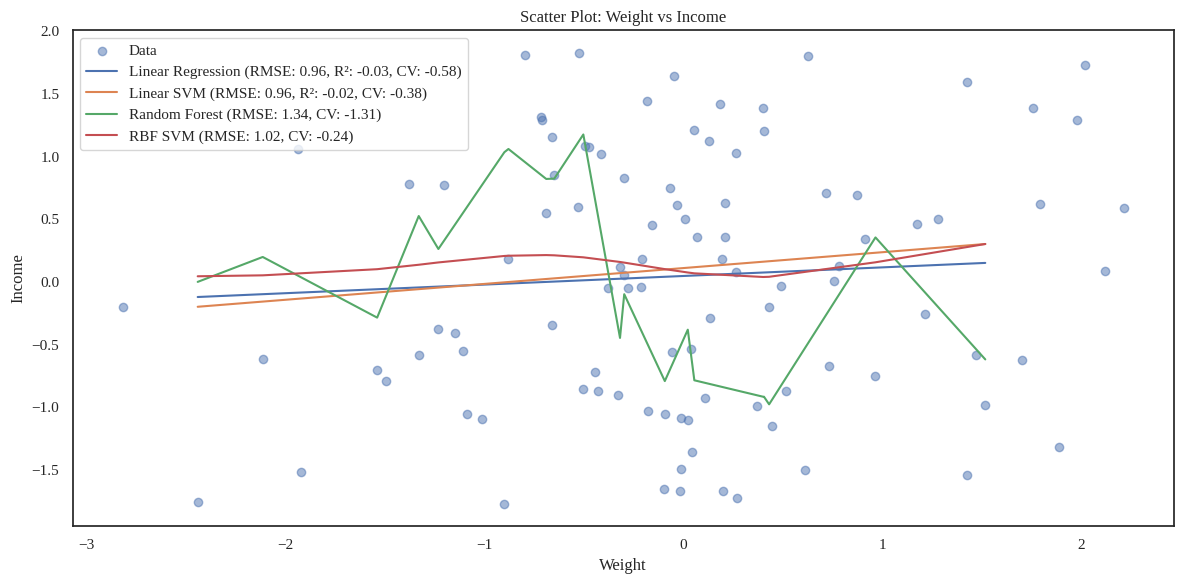

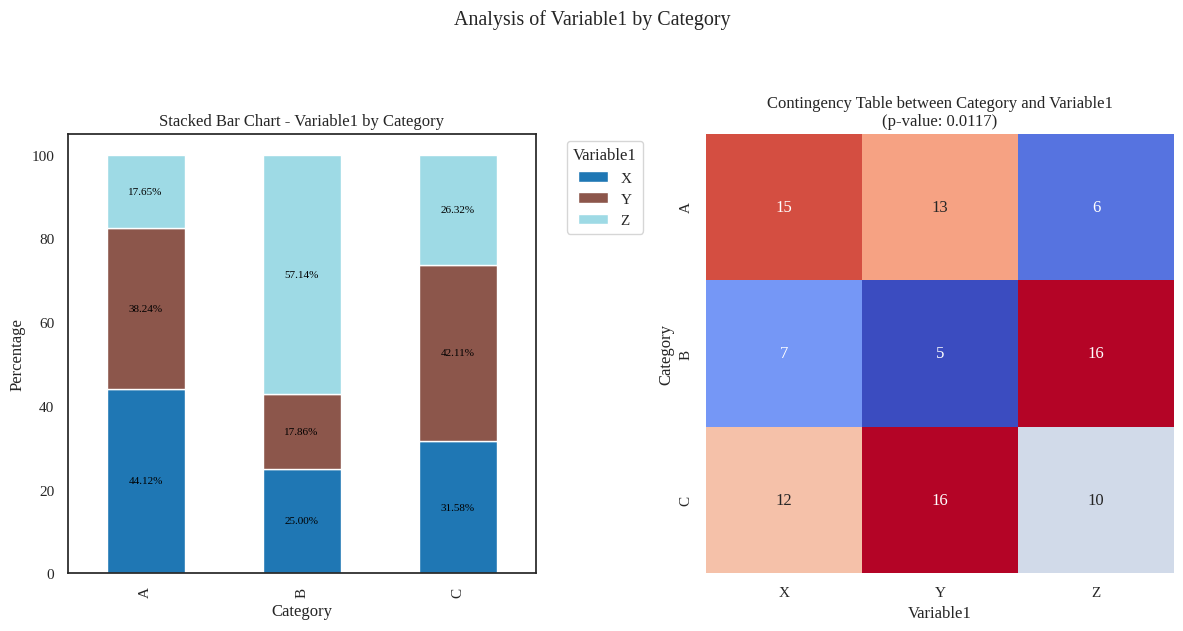

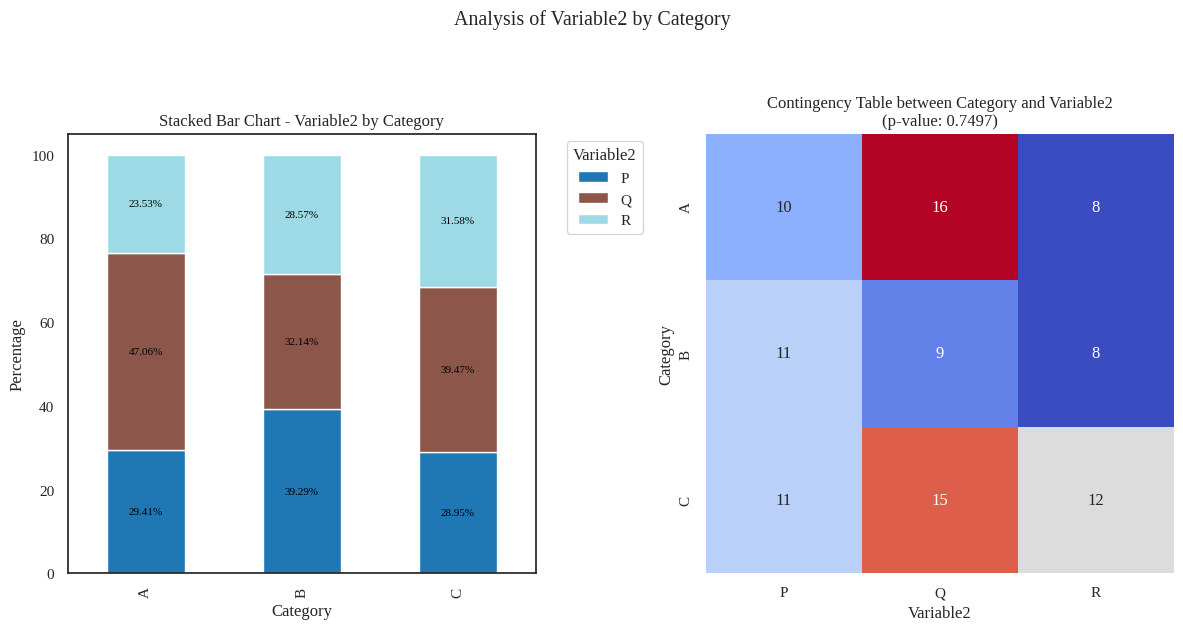

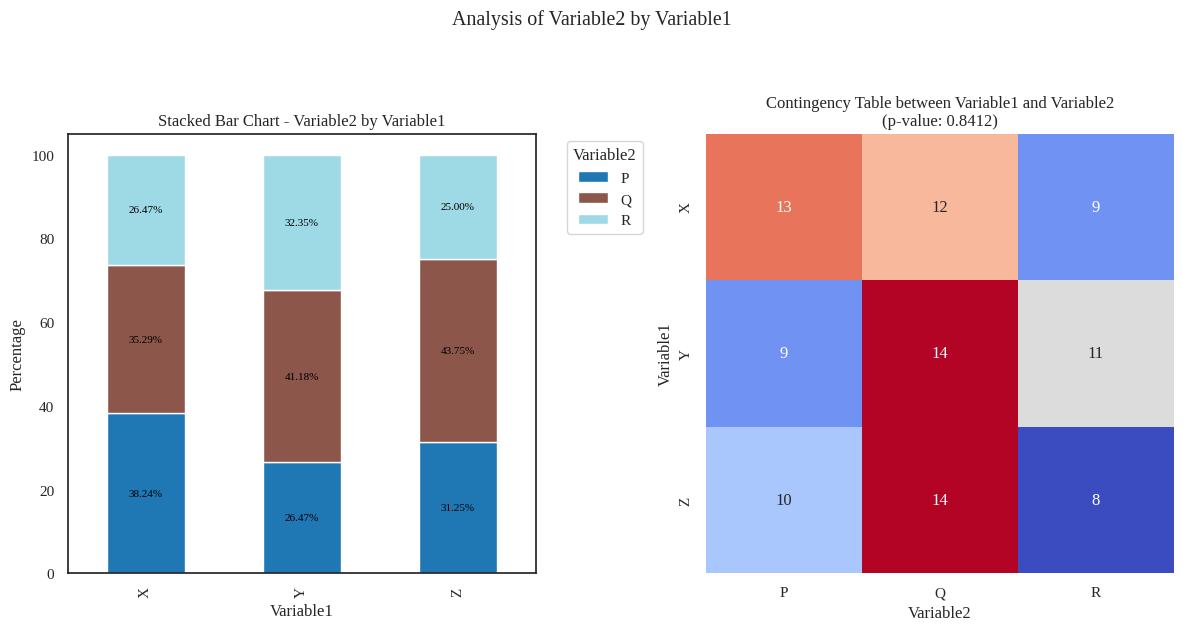

Normality and homoscedasticity tests performed and saved in tables.
Linear models evaluated and results saved.
Report generated at Analyzed_Dataset_20241017_193505/reports/Dataset_Analysis_Report.docx


In [3]:
# Run the data analysis function
analyze_dataset(df)